In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os.path as op
import glob
import matplotlib.pyplot as plt
import ast
# import moss
import csv
import random
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

from statsmodels.stats.anova import AnovaRM


In [2]:
df = pd.read_csv('pilot5_shuffled_nonresp_inc.csv')
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns


In [3]:
def remove_unit_variance(df, col, unit, group=None, suffix="_within"):
    """Remove variance between sampling units.

    This is useful for plotting repeated-measures data using within-unit
    error bars.

    Parameters
    ----------
    df : DataFrame
        Input data. Will have a new column added.
    col : column name
        Column in dataframe with quantitative measure to modify.
    unit : column name
        Column in dataframe defining sampling units (e.g., subjects).
    group : column name(s), optional
        Columns defining groups to remove unit variance within.
    suffix : string, optional
        Suffix appended to ``col`` name to create new column.

    Returns
    -------
    df : DataFrame
        Returns modified dataframe.

    """
    new_col = col + suffix

    def demean(x):
        return x - x.mean()

    if group is None:
        new = df.groupby(unit)[col].transform(demean)
        new += df[col].mean()
        df.loc[:, new_col] = new
    else:
        df.loc[:, new_col] = np.nan
        for level, df_level in df.groupby(group):
            new = df_level.groupby(unit)[col].transform(demean)
            new += df_level[col].mean()
            df.loc[new.index, new_col] = new

    return df

In [4]:
df = remove_unit_variance(df,'mouse.time_last','participant')
df['analysis_rt'] = df['mouse.time_last_within']

In [5]:
palette = sns.color_palette("husl", n_colors=2)[::-1]  # Reverse the color order


In [6]:
df['IT Distractor Similarity\nto Prioritized Item']

0                  NaN
1                  NaN
2                  NaN
3         Most Similar
4                     
             ...      
40195    Least Similar
40196     Most Similar
40197    Least Similar
40198                 
40199              NaN
Name: IT Distractor Similarity\nto Prioritized Item, Length: 40200, dtype: object

In [7]:
df['Distractor V2 Similarity Preference'] = df['v2_prefers'] 
df['Distractor IT Similarity Preference'] = df['it_prefers']


column_params = {
    'v2': {'n_cats': 5, 'labels': ['Least Similar', '', ' ', '   ', 'Most Similar']},
    'it': {'n_cats': 5, 'labels': ['Least Similar', '', ' ', '   ', 'Most Similar']}
}

for label in ['it_sim_dis_attend', 'v2_sim_dis_attend', 'it_sim_dis_unattend', 'v2_sim_dis_unattend', 'it_sim_dis_diff', 'v2_sim_dis_diff','v2_sim_dis_diff_sq', 'it_sim_dis_diff_sq']:
    
    if 'v2' in label:
        n_cats = column_params['v2']['n_cats']
        labels = column_params['v2']['labels']
    else:
        n_cats = column_params['it']['n_cats']
        labels = column_params['it']['labels']
    
    df[label + '_cat'] = pd.qcut(df[label], q=n_cats, labels=labels, duplicates='drop')


df['V2 Distractor Similarity\nto Prioritized Item'] = df['v2_sim_dis_attend_cat']
df['IT Distractor Similarity\nto Prioritized Item'] = df['it_sim_dis_attend_cat']
df['V2 Distractor Similarity\nto Deprioritized Item'] = df['v2_sim_dis_unattend_cat']
df['IT Distractor Similarity\nto Deprioritized Item'] = df['it_sim_dis_unattend_cat']
df['Prioritized - Deprioritized IT Distractor Similarity'] = df['it_sim_dis_diff_cat'] 
df['Prioritized - Deprioritized V2 Distractor Similarity'] = df['v2_sim_dis_diff_cat'] 
df['Prioritized - Deprioritized IT Distractor Similarity Squared'] = df['v2_sim_dis_diff_sq_cat'] 
df['Prioritized - Deprioritized V2 Distractor Similarity Squared'] = df['it_sim_dis_diff_sq_cat'] 


In [8]:
df['it_sim_dis_diff'] = df['it_sim_dis_diff'] - np.mean(df['it_sim_dis_diff'])
df['v2_sim_dis_diff'] = df['v2_sim_dis_diff'] - np.mean(df['v2_sim_dis_diff'])

df['it_sim_dis_diff_sq'] = [x**2 for x in df['it_sim_dis_diff']]
df['v2_sim_dis_diff_sq'] = [x**2 for x in df['v2_sim_dis_diff']]

df['it_sim_dis_diff_sq'] = df['it_sim_dis_diff_sq'] - np.mean(df['it_sim_dis_diff_sq'])
df['v2_sim_dis_diff_sq'] = df['v2_sim_dis_diff_sq'] - np.mean(df['v2_sim_dis_diff_sq'])


df['IT_diff_binned'] = pd.qcut(df['it_sim_dis_diff'], 5, duplicates='drop')
df['V2_diff_binned'] = pd.qcut(df['v2_sim_dis_diff'], 5, duplicates='drop')
df['IT_diff_binned_sq'] = pd.qcut(df['it_sim_dis_diff_sq'], 5, duplicates='drop')
df['V2_diff_binned_sq'] = pd.qcut(df['v2_sim_dis_diff_sq'], 5, duplicates='drop')

def round_to_significant_figures(x, sig_figs=2):
    if x == 0:
        return 0
    else:
        return round(x, sig_figs - int(np.floor(np.log10(abs(x)))) - 1)


def process_interval(interval):
    # Round both bounds
    lower_rounded = round_to_significant_figures(interval.left)
    upper_rounded = round_to_significant_figures(interval.right)
    # Return a new interval with the rounded bounds
    return pd.Interval(lower_rounded, upper_rounded)

df['IT_diff_binned'] = df['IT_diff_binned'].apply(process_interval)
df['V2_diff_binned'] = df['V2_diff_binned'].apply(process_interval)
df['IT_diff_binned_sq'] = df['IT_diff_binned_sq'].apply(process_interval)
df['V2_diff_binned_sq'] = df['V2_diff_binned_sq'].apply(process_interval)

df['Prioritized - Deprioritized V2 Distractor Similarity Ranges'] = df['V2_diff_binned']
df['Prioritized - Deprioritized IT Distractor Similarity Ranges'] = df['IT_diff_binned']
df['Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges'] = df['V2_diff_binned_sq']
df['Prioritized - Deprioritized IT Distractor Similarity Squared Ranges'] = df['IT_diff_binned_sq']

In [9]:
df['tested_item'] = df['Tested Item']
df['ret_rel'] = df['Retrocue Reliability']

In [10]:
len(set(df['participant']))

134

In [11]:
df_correct = df[df['resp_correct'] == 1]


In [12]:
df

,setup_js.started,setup_js.stopped,participant,date,expName,psychopyVersion,OS,frameRate,Instructions1.started,Instructions1.stopped,...,Prioritized - Deprioritized IT Distractor Similarity Squared,Prioritized - Deprioritized V2 Distractor Similarity Squared,IT_diff_binned_sq,V2_diff_binned_sq,Prioritized - Deprioritized V2 Distractor Similarity Ranges,Prioritized - Deprioritized IT Distractor Similarity Ranges,Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges,Prioritized - Deprioritized IT Distractor Similarity Squared Ranges,tested_item,ret_rel
0,NaN,NaN,116851,2024-10-12 15:22:21.820,WM_Deepgen,2024.1.5,Win32,59.52381,NaN,NaN,...,,Least Similar,"(-0.54, -0.44]","(0.0012, 0.0089]","(0.1, 0.17]","(-0.35, 0.25]","(0.0012, 0.0089]","(-0.54, -0.44]",prioritized,low
1,NaN,NaN,116851,2024-10-12 15:22:21.820,WM_Deepgen,2024.1.5,Win32,59.52381,NaN,NaN,...,Least Similar,Least Similar,"(-0.54, -0.44]","(-0.011, -0.0081]","(-0.041, 0.042]","(-0.35, 0.25]","(-0.011, -0.0081]","(-0.54, -0.44]",prioritized,low
2,NaN,NaN,116851,2024-10-12 15:22:21.820,WM_Deepgen,2024.1.5,Win32,59.52381,NaN,NaN,...,,,"(-0.25, 0.042]","(-0.0081, -0.0047]","(0.042, 0.1]","(-0.73, -0.35]","(-0.0081, -0.0047]","(-0.25, 0.042]",deprioritized,high
3,NaN,NaN,116851,2024-10-12 15:22:21.820,WM_Deepgen,2024.1.5,Win32,59.52381,NaN,NaN,...,,Most Similar,"(0.43, 0.91]","(-0.0081, -0.0047]","(-0.11, -0.041]","(0.83, 1.2]","(-0.0081, -0.0047]","(0.43, 0.91]",prioritized,low
4,NaN,NaN,116851,2024-10-12 15:22:21.820,WM_Deepgen,2024.1.5,Win32,59.52381,NaN,NaN,...,Most Similar,,"(-0.25, 0.042]","(0.0089, 0.02]","(-0.17, -0.11]","(0.25, 0.83]","(0.0089, 0.02]","(-0.25, 0.042]",deprioritized,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40195,NaN,NaN,167080,2024-10-28 17:42:43.597,WM_Deepgen,2023.2.1,MacIntel,62.50000,NaN,NaN,...,Least Similar,,"(-0.25, 0.042]","(-0.011, -0.0081]","(-0.041, 0.042]","(-0.73, -0.35]","(-0.011, -0.0081]","(-0.25, 0.042]",prioritized,high
40196,NaN,NaN,167080,2024-10-28 17:42:43.597,WM_Deepgen,2023.2.1,MacIntel,62.50000,NaN,NaN,...,,Least Similar,"(-0.54, -0.44]","(-0.0081, -0.0047]","(0.042, 0.1]","(-0.35, 0.25]","(-0.0081, -0.0047]","(-0.54, -0.44]",deprioritized,high
40197,NaN,NaN,167080,2024-10-28 17:42:43.597,WM_Deepgen,2023.2.1,MacIntel,62.50000,NaN,NaN,...,,,"(0.042, 0.43]","(0.0012, 0.0089]","(-0.17, -0.11]","(-1.2, -0.73]","(0.0012, 0.0089]","(0.042, 0.43]",prioritized,low
40198,NaN,NaN,167080,2024-10-28 17:42:43.597,WM_Deepgen,2023.2.1,MacIntel,62.50000,NaN,NaN,...,,,"(-0.44, -0.25]","(0.0012, 0.0089]","(0.1, 0.17]","(0.25, 0.83]","(0.0012, 0.0089]","(-0.44, -0.25]",deprioritized,low


<Figure size 1000x600 with 0 Axes>

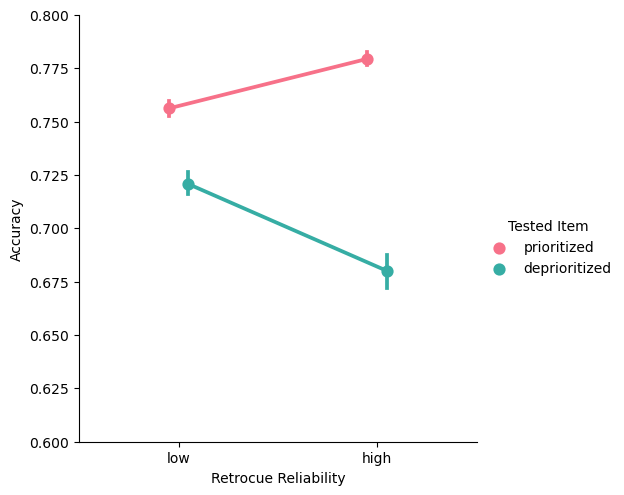

In [13]:

plt.figure(figsize=(10, 6))
sns.catplot(
    x='Retrocue Reliability',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    order = ['low','high'],
#     col = 'participant',
    kind = 'point',
    hue='Tested Item',
    dodge=0.1,
    palette=palette[::-1],  # Use the single-color palette
    data=df
)
plt.ylim(0.6, 0.8)
plt.ylabel('Accuracy')
# plt.xlabel('V2 Distractor Similarity to Prioritized Item')
# plt.title('Accuracy by V2 Distractor Similarity')
plt.show()


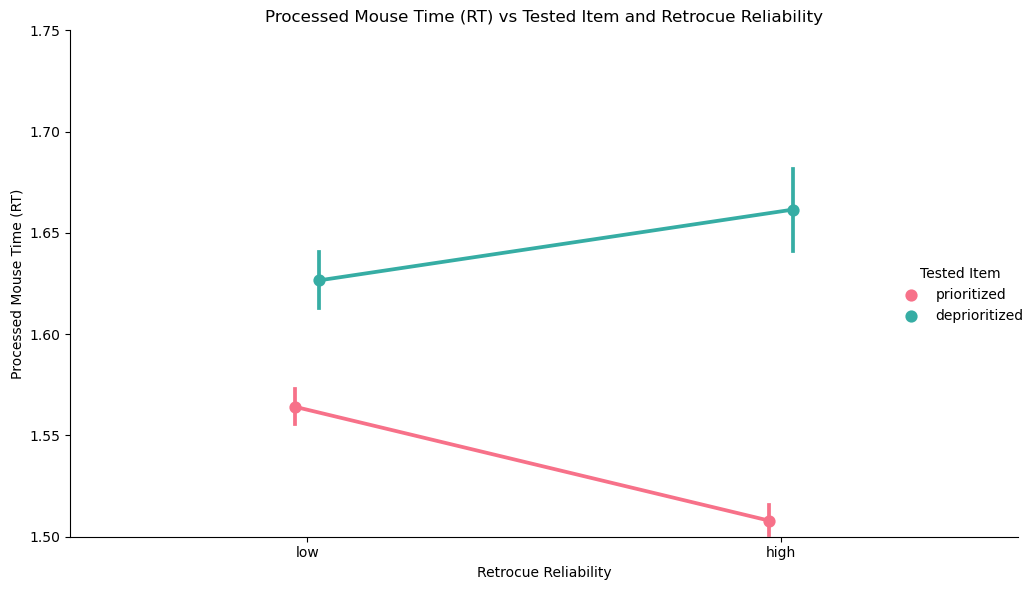

In [14]:
g = sns.catplot(x='Retrocue Reliability', y='analysis_rt', hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            order=['low', 'high'],  # Specify the order of the categories
            palette = palette[::-1])
g.set(ylim=(1.5, 1.75))

plt.xlabel('Retrocue Reliability')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Tested Item and Retrocue Reliability')
plt.tight_layout()
plt.show()

In [15]:
df['V2 Distractor Similarity\nto Prioritized Item']

0                     
1                     
2                     
3                     
4        Least Similar
             ...      
40195                 
40196                 
40197                 
40198                 
40199                 
Name: V2 Distractor Similarity\nto Prioritized Item, Length: 40200, dtype: category
Categories (5, object): ['Least Similar' < '' < ' ' < '   ' < 'Most Similar']

In [16]:
# nan_values = df['V2 Distractor Similarity\nto Prioritized Item'].isna()
# rows_with_nan = df[nan_values]
# print(rows_with_nan)


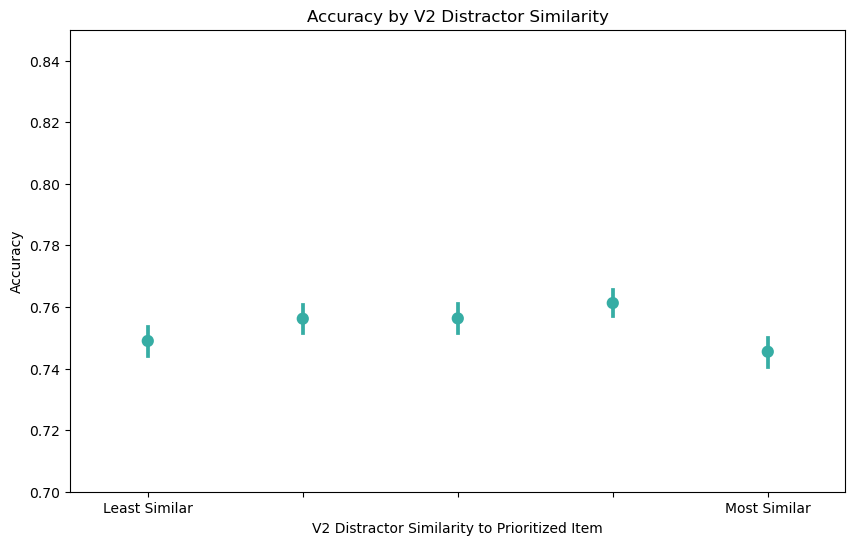

In [17]:
single_color = palette[0]  # Use the first color from the palette
single_color_palette = [single_color]

plt.figure(figsize=(10, 6))
sns.pointplot(
    x='V2 Distractor Similarity\nto Prioritized Item',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.1,
    palette=single_color_palette,  # Use the single-color palette
    data=df
)
plt.ylim(0.7, 0.85)
plt.ylabel('Accuracy')
plt.xlabel('V2 Distractor Similarity to Prioritized Item')
plt.title('Accuracy by V2 Distractor Similarity')
plt.show()


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/1190682690.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(44.99652777777777, 0.5, 'Accuracy')

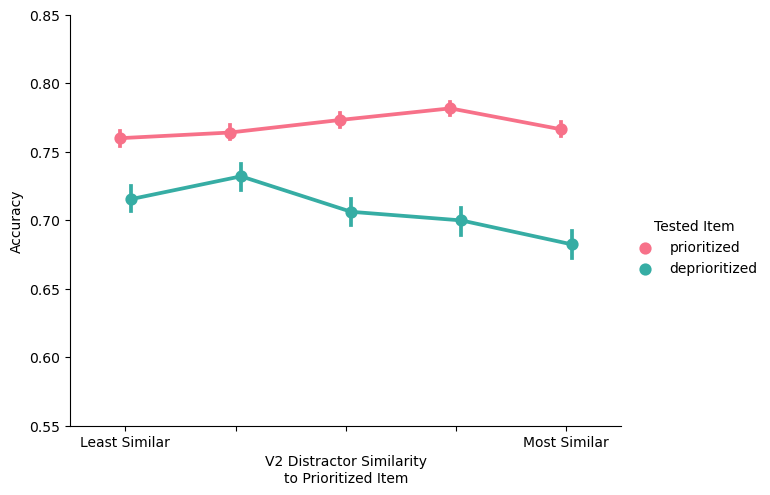

In [18]:
g = sns.catplot(
            x = 'V2 Distractor Similarity\nto Prioritized Item',
            y = 'Accuracy',
            ci = 68,
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.ylabel('Accuracy')


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/1289384816.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(45.877985517568845, 0.5, 'Accuracy')

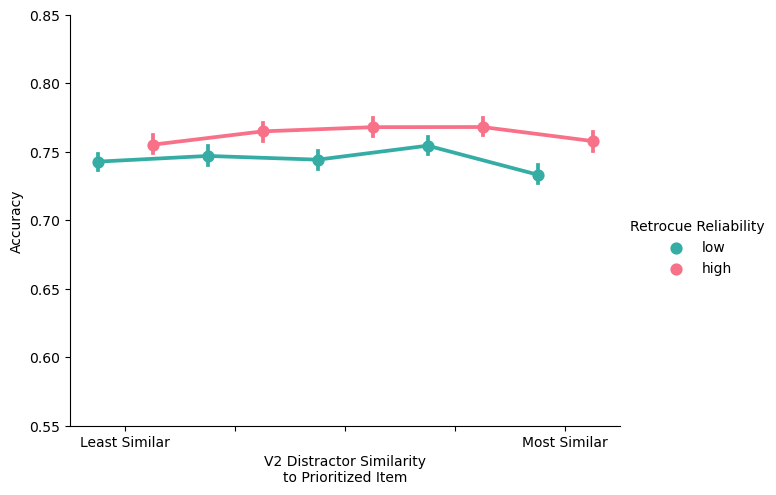

In [19]:
g = sns.catplot(
            x = 'V2 Distractor Similarity\nto Prioritized Item',
            y = 'Accuracy',
            ci = 68,
            hue = 'Retrocue Reliability',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.5,
            kind = 'point',
            palette = palette,  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.ylabel('Accuracy')


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/3059318271.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


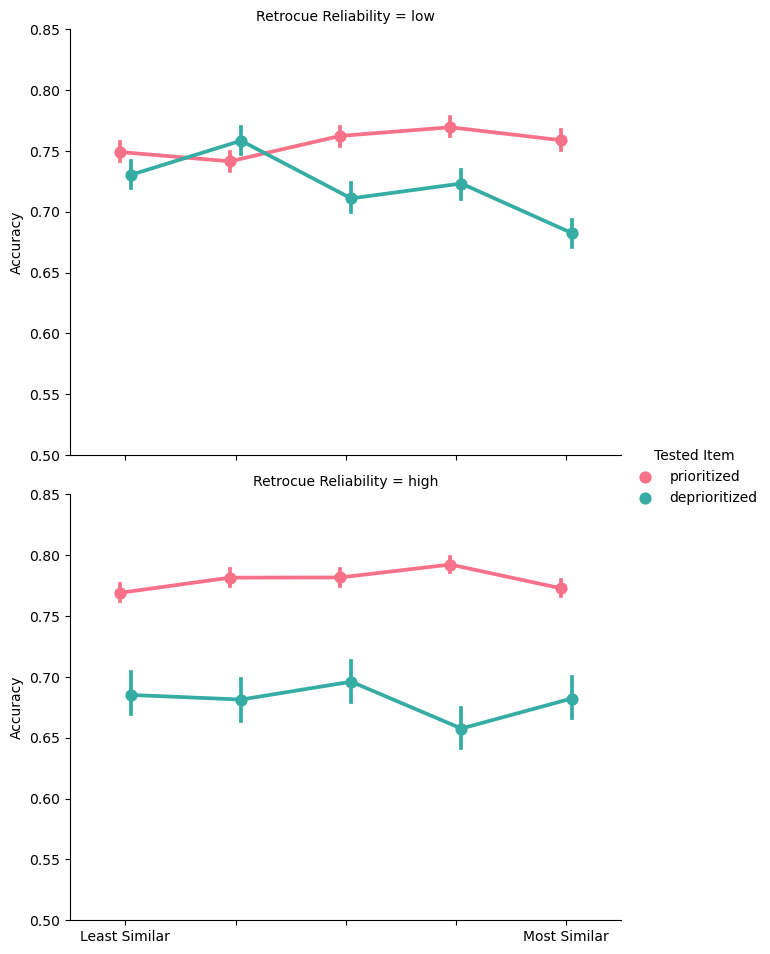

In [20]:
g = sns.catplot(
    x='V2 Distractor Similarity\nto Prioritized Item',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',  # Use 'row' instead of 'col' to arrange plots vertically
    aspect=1.3,
    dodge=0.1,
    kind='point',
    row_order = ['low', 'high'],
    palette=palette[::-1],  # Reverse the color order
    data=df
)
g.set(ylim=(0.50, 0.85))
g.set_axis_labels("", "Accuracy")

plt.show()

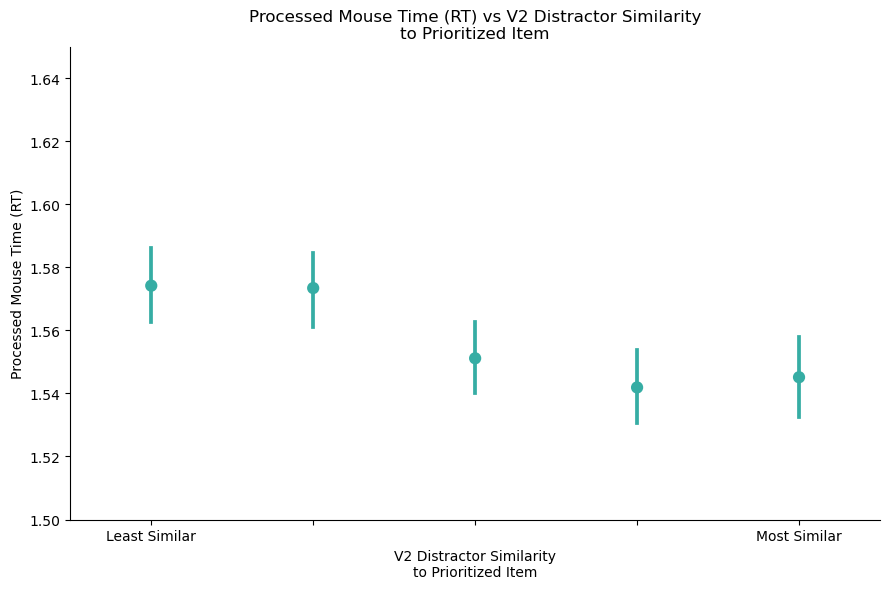

In [21]:
g = sns.catplot(x='V2 Distractor Similarity\nto Prioritized Item', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.65))

plt.xlabel('V2 Distractor Similarity\nto Prioritized Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()

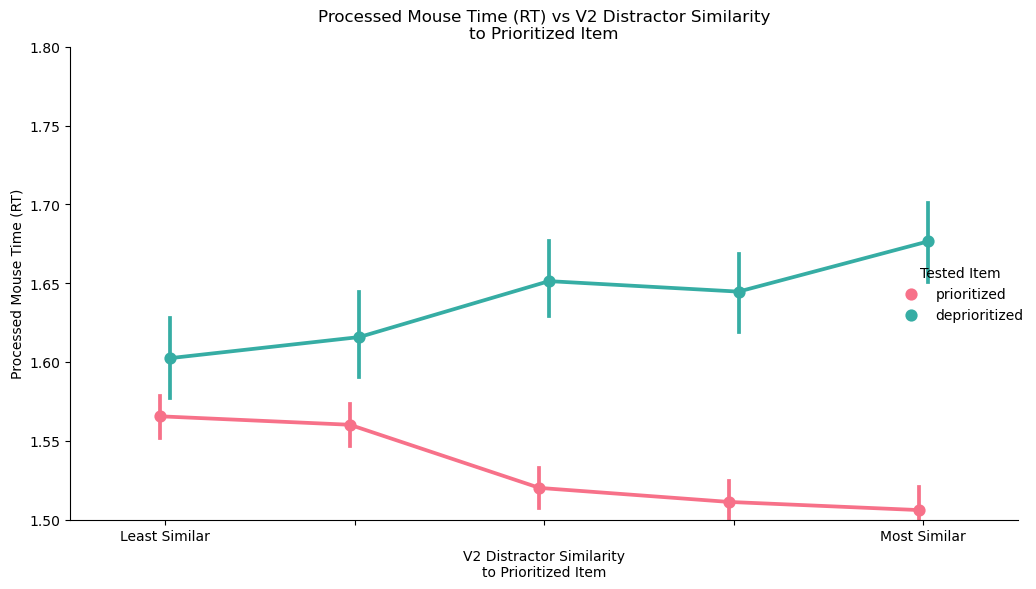

In [22]:
g = sns.catplot(x='V2 Distractor Similarity\nto Prioritized Item', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.5, 1.8))

plt.xlabel('V2 Distractor Similarity\nto Prioritized Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()

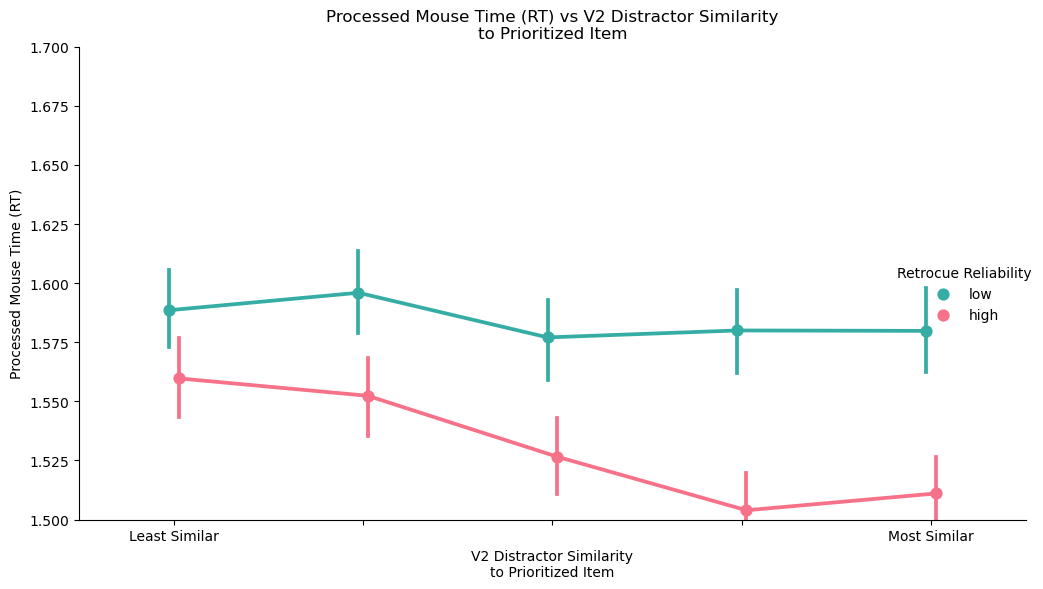

In [23]:
g = sns.catplot(x='V2 Distractor Similarity\nto Prioritized Item', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.7))

plt.xlabel('V2 Distractor Similarity\nto Prioritized Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()

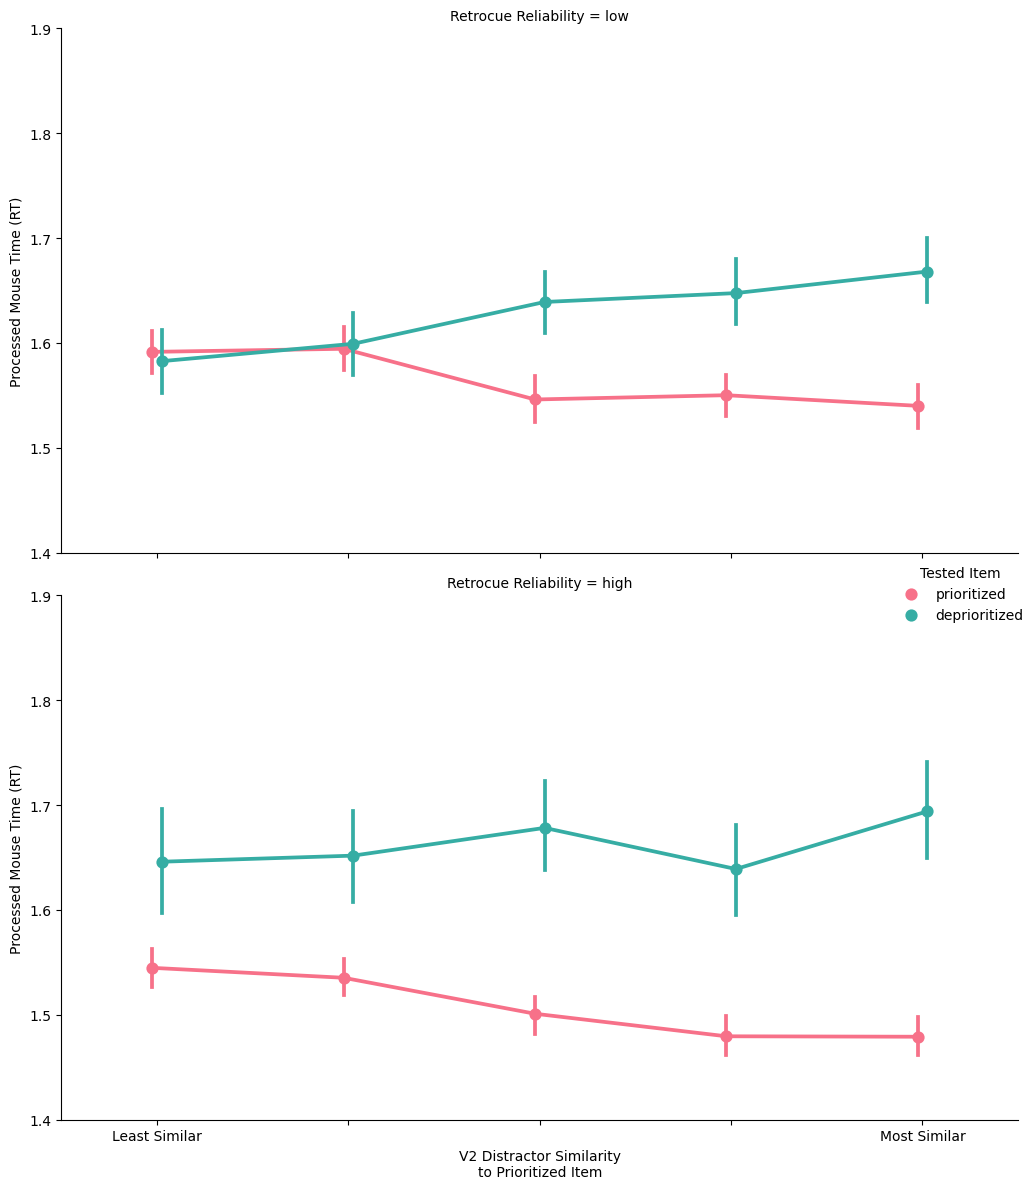

In [24]:
g = sns.catplot(x='V2 Distractor Similarity\nto Prioritized Item', y='analysis_rt', 
                hue='Tested Item', row='Retrocue Reliability',  # Use 'row' instead of 'col'
                kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
                palette=palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.9))

g.set_axis_labels('V2 Distractor Similarity\nto Prioritized Item', 'Processed Mouse Time (RT)')
plt.tight_layout()
plt.show()

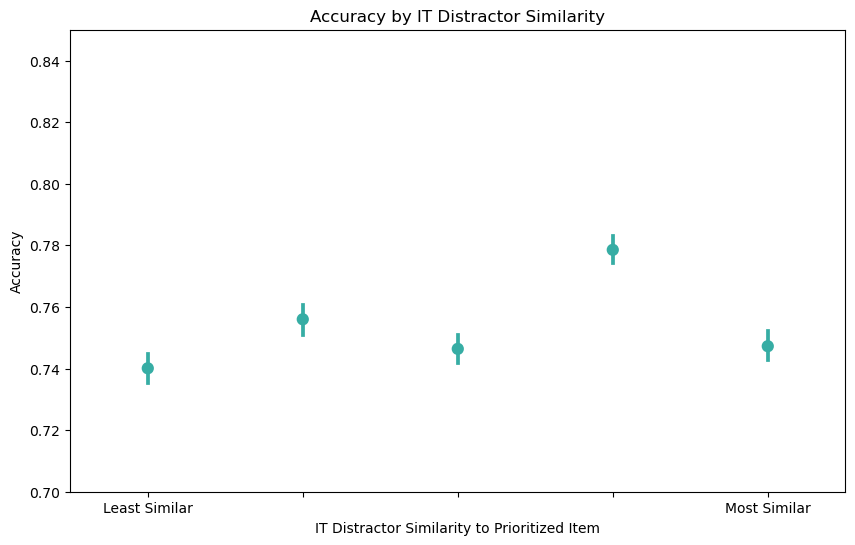

In [25]:


plt.figure(figsize=(10, 6))
sns.pointplot(
    x='IT Distractor Similarity\nto Prioritized Item',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.1,
    palette=single_color_palette,  # Use the single-color palette
    data=df
)
plt.ylim(0.7, 0.85)
plt.ylabel('Accuracy')
plt.xlabel('IT Distractor Similarity to Prioritized Item')
plt.title('Accuracy by IT Distractor Similarity')
plt.show()


In [26]:
df['validity_binary'] = df['Tested Item'].apply(lambda x: 1 if x == 'prioritized' else 0)
df['reliability_binary'] = df['Retrocue Reliability'].apply(lambda x: 1 if x == 'high' else 0)


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/2234716875.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


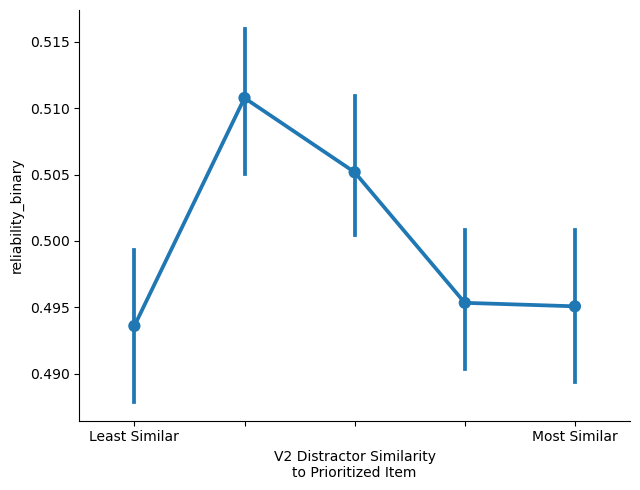

In [27]:

# plt.figure(figsize=(10, 6))
# sns.pointplot(
#     x='IT Distractor Similarity\nto Prioritized Item',
#     y='Tested Item',
#     errorbar=('ci', 68),  # Updated error bar parameter
#     dodge=0.5,
#     palette=single_color_palette,  # Use the single-color palette
#     data=df
# )
# plt.ylim(0.7, 0.85)
# plt.ylabel('Accuracy')
# plt.xlabel('IT Distractor Similarity to Prioritized Item')
# plt.title('Accuracy by IT Distractor Similarity')
# plt.show()



g = sns.catplot(
    x='V2 Distractor Similarity\nto Prioritized Item',
    y='reliability_binary',
    ci=68,
#     hue='Tested Item',
#     row='Retrocue Reliability',  # Use 'row' instead of 'col' to arrange plots vertically
    aspect=1.3,
    dodge=0.1,
    kind='point',
    row_order = ['low', 'high'],
#     palette=palette,  # Reverse the color order
    data=df)


plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/2990378629.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(44.99652777777777, 0.5, 'Accuracy')

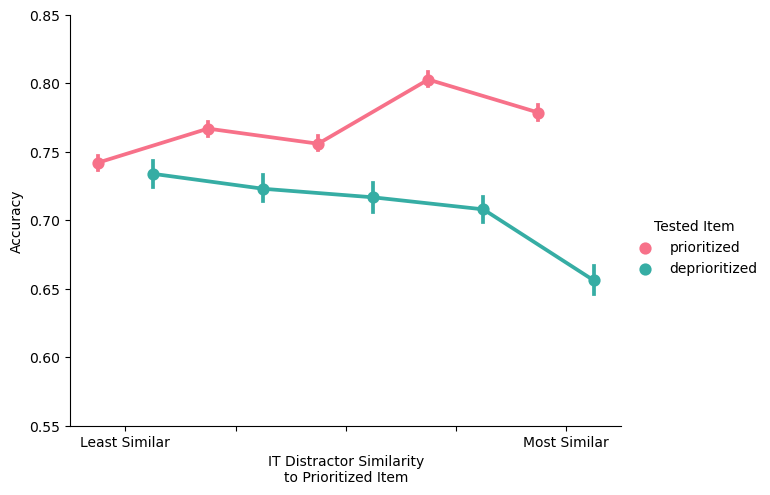

In [28]:
g = sns.catplot(
            x = 'IT Distractor Similarity\nto Prioritized Item',
            y = 'Accuracy',
            ci = 68,
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.5,
            kind = 'point',
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/2304160147.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(45.877985517568845, 0.5, 'Accuracy')

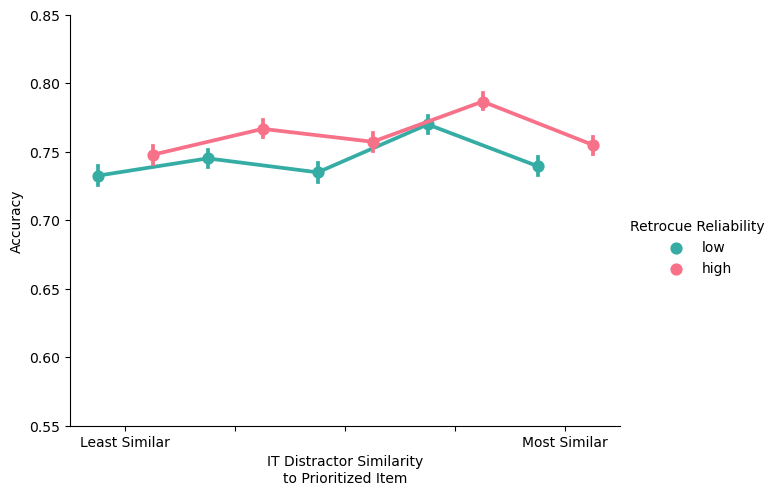

In [29]:
g = sns.catplot(
            x = 'IT Distractor Similarity\nto Prioritized Item',
            y = 'Accuracy',
            ci = 68,
            hue = 'Retrocue Reliability',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.5,
            kind = 'point',
            palette = palette,  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/2385623800.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


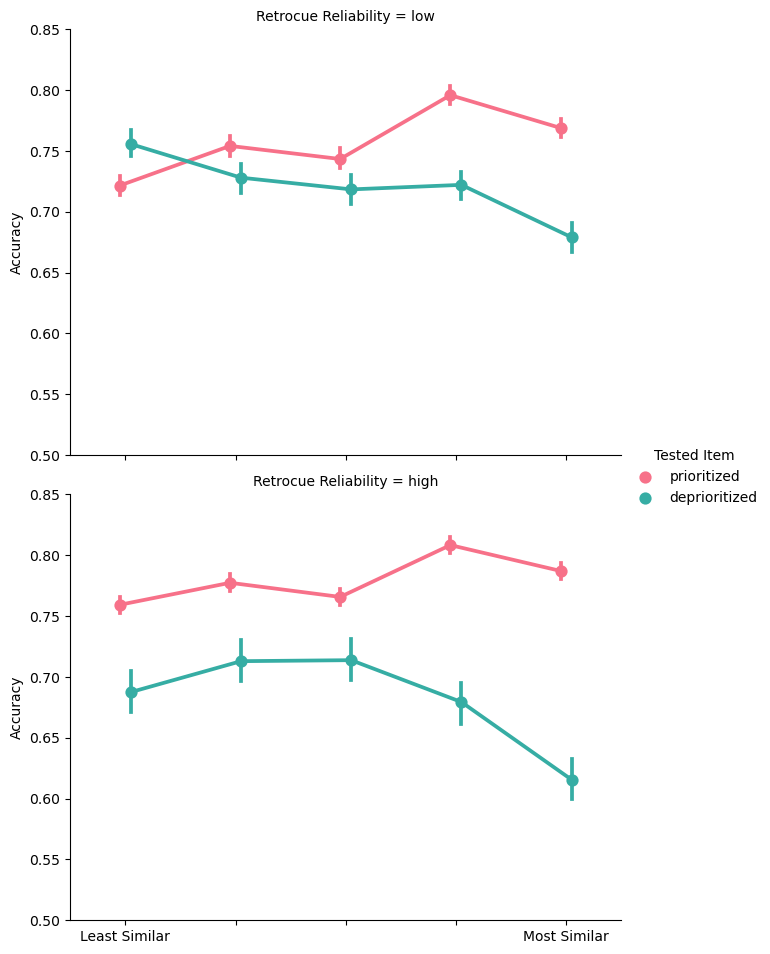

In [30]:
g = sns.catplot(
    x='IT Distractor Similarity\nto Prioritized Item',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    
    row='Retrocue Reliability',  # Use 'row' instead of 'col' to arrange plots vertically
    aspect=1.3,
    row_order = ['low', 'high'],
    dodge=0.1,
    kind='point',
    palette=palette[::-1],  # Reverse the color order
    data=df
)
g.set(ylim=(0.5, 0.85))
g.set_axis_labels("", "Accuracy")

plt.show()

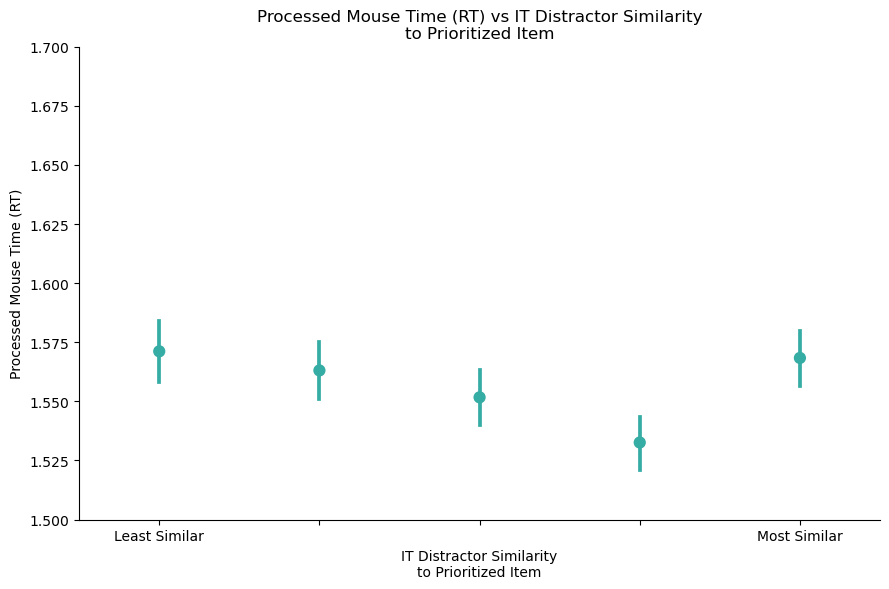

In [31]:
g = sns.catplot(x='IT Distractor Similarity\nto Prioritized Item', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.7))

plt.xlabel('IT Distractor Similarity\nto Prioritized Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs IT Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()

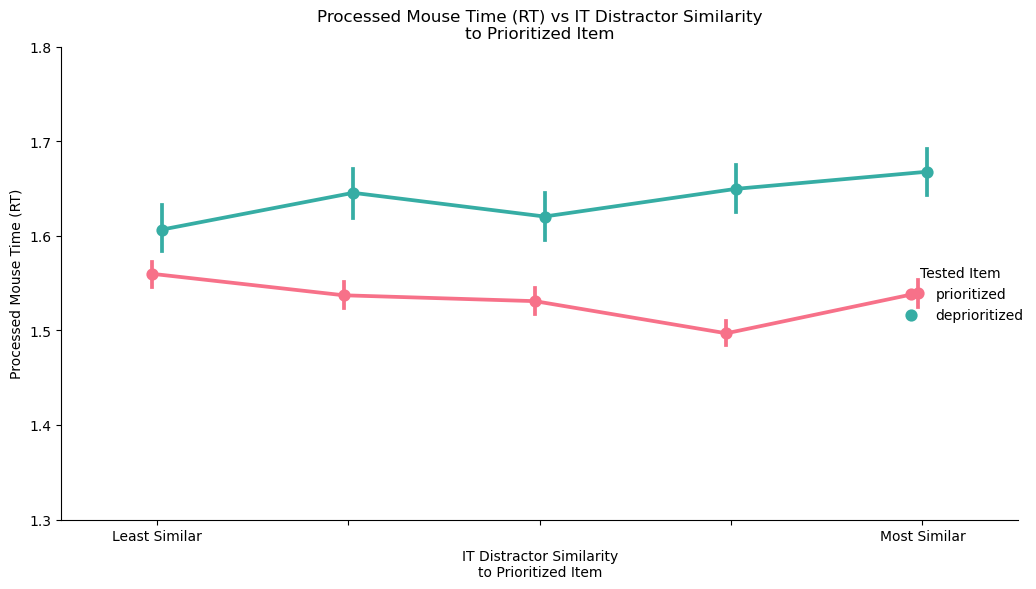

In [32]:
g = sns.catplot(x='IT Distractor Similarity\nto Prioritized Item', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.3, 1.8))

plt.xlabel('IT Distractor Similarity\nto Prioritized Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs IT Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()

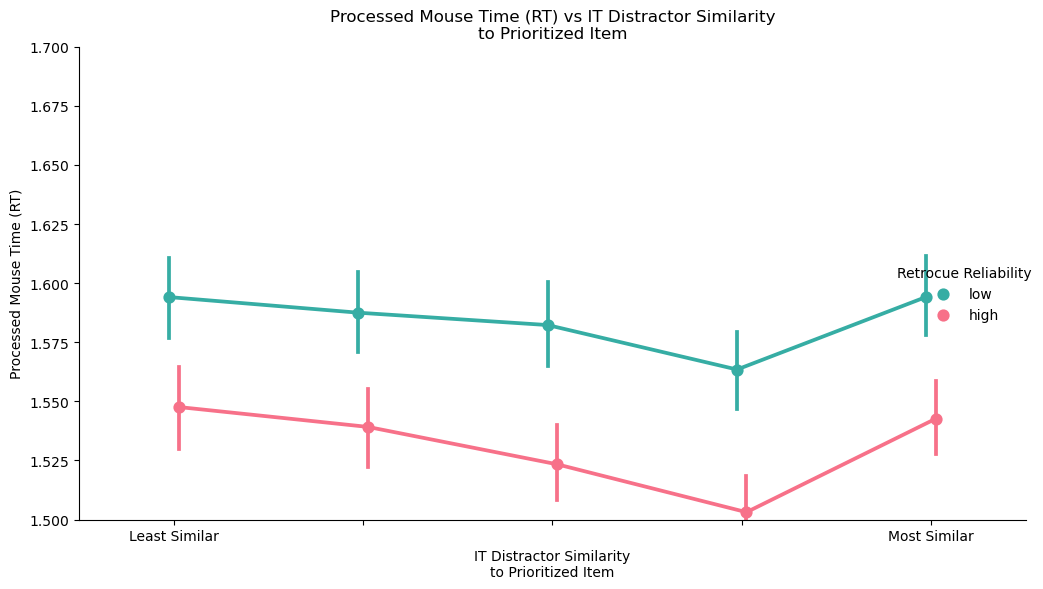

In [33]:
g = sns.catplot(x='IT Distractor Similarity\nto Prioritized Item', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.7))

plt.xlabel('IT Distractor Similarity\nto Prioritized Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs IT Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()

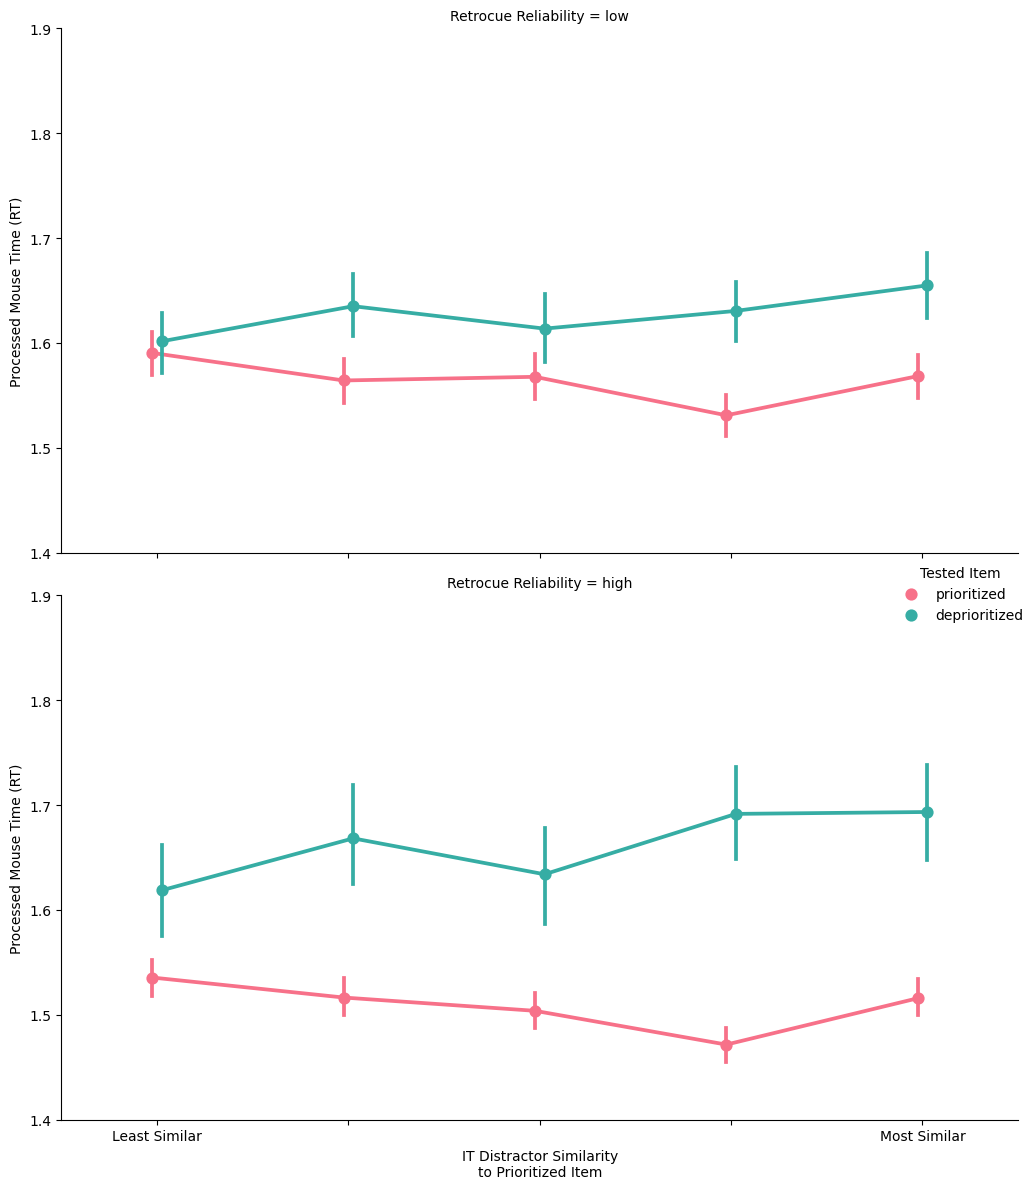

In [34]:
g = sns.catplot(x='IT Distractor Similarity\nto Prioritized Item', y='analysis_rt', 
                hue='Tested Item', row='Retrocue Reliability',  # Use 'row' instead of 'col'
                kind='point',row_order = ['low', 'high'], data=df_correct, dodge=True, height=6, aspect=1.5, 
                palette=palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.9))

g.set_axis_labels('IT Distractor Similarity\nto Prioritized Item', 'Processed Mouse Time (RT)')
plt.tight_layout()
plt.show()

In [35]:
# df['IT_diff_binned'] = pd.qcut(df['it_sim_dis_diff'], 5, duplicates='drop')
# df['V2_diff_binned'] = pd.qcut(df['v2_sim_dis_diff'], 5, duplicates='drop')

# def round_to_significant_figures(x, sig_figs=2):
#     if x == 0:
#         return 0
#     else:
#         return round(x, sig_figs - int(np.floor(np.log10(abs(x)))) - 1)


# def process_interval(interval):
#     # Round both bounds
#     lower_rounded = round_to_significant_figures(interval.left)
#     upper_rounded = round_to_significant_figures(interval.right)
#     # Return a new interval with the rounded bounds
#     return pd.Interval(lower_rounded, upper_rounded)

# df['IT_diff_binned'] = df['IT_diff_binned'].apply(process_interval)
# df['V2_diff_binned'] = df['V2_diff_binned'].apply(process_interval)

# df['Prioritized - Deprioritized V2 Distractor Similarity Ranges'] = df['V2_diff_binned']
# df['Prioritized - Deprioritized IT Distractor Similarity Ranges'] = df['IT_diff_binned']

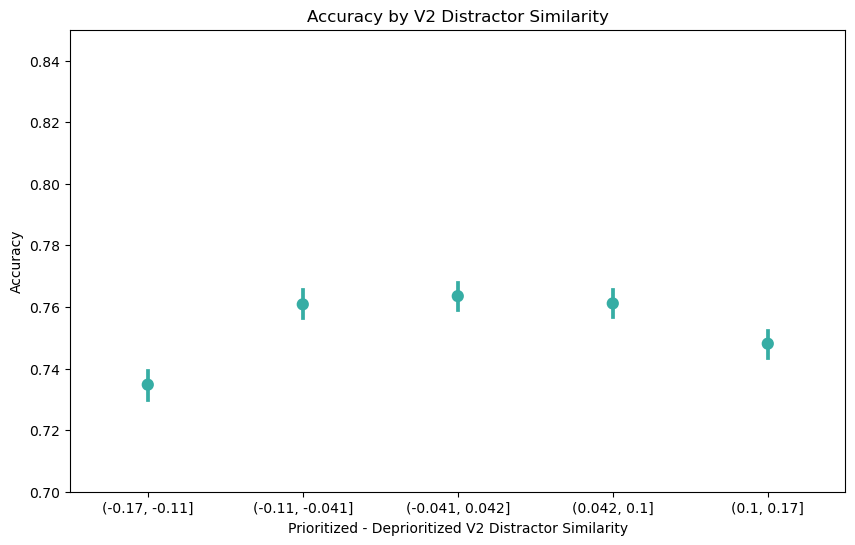

In [36]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='V2_diff_binned',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.1,
    palette=single_color_palette,  # Use the single-color palette
    data=df
)
plt.ylim(0.7, 0.85)
plt.ylabel('Accuracy')
plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity')
plt.title('Accuracy by V2 Distractor Similarity')
plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/741286795.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(44.99652777777777, 0.5, 'Accuracy')

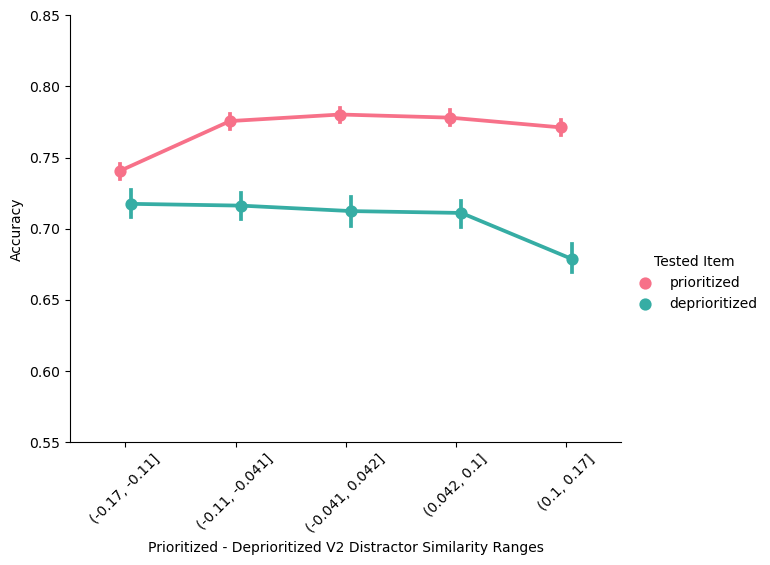

In [37]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized V2 Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/1754270446.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(45.877985517568845, 0.5, 'Accuracy')

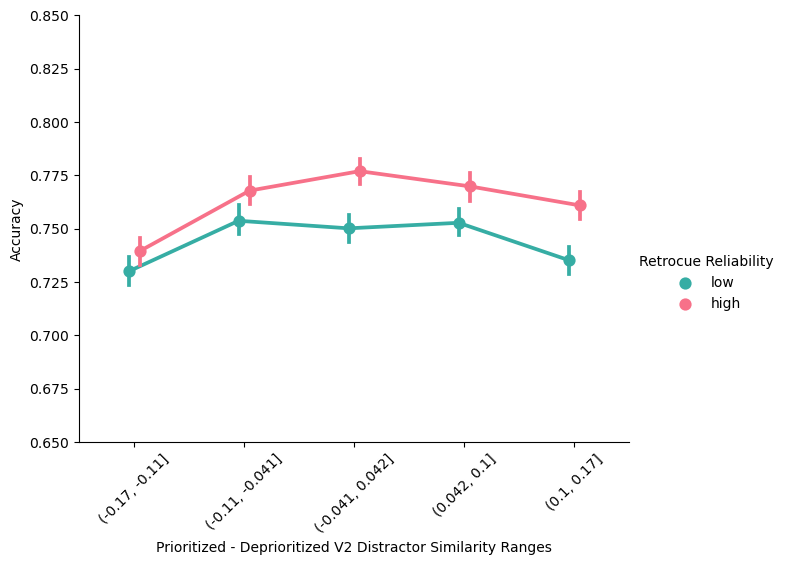

In [38]:



g = sns.catplot(
            x = 'Prioritized - Deprioritized V2 Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Retrocue Reliability',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette,  # Reverse the color order
            data = df)
g.set(ylim=(0.65, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')



/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/1572650511.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


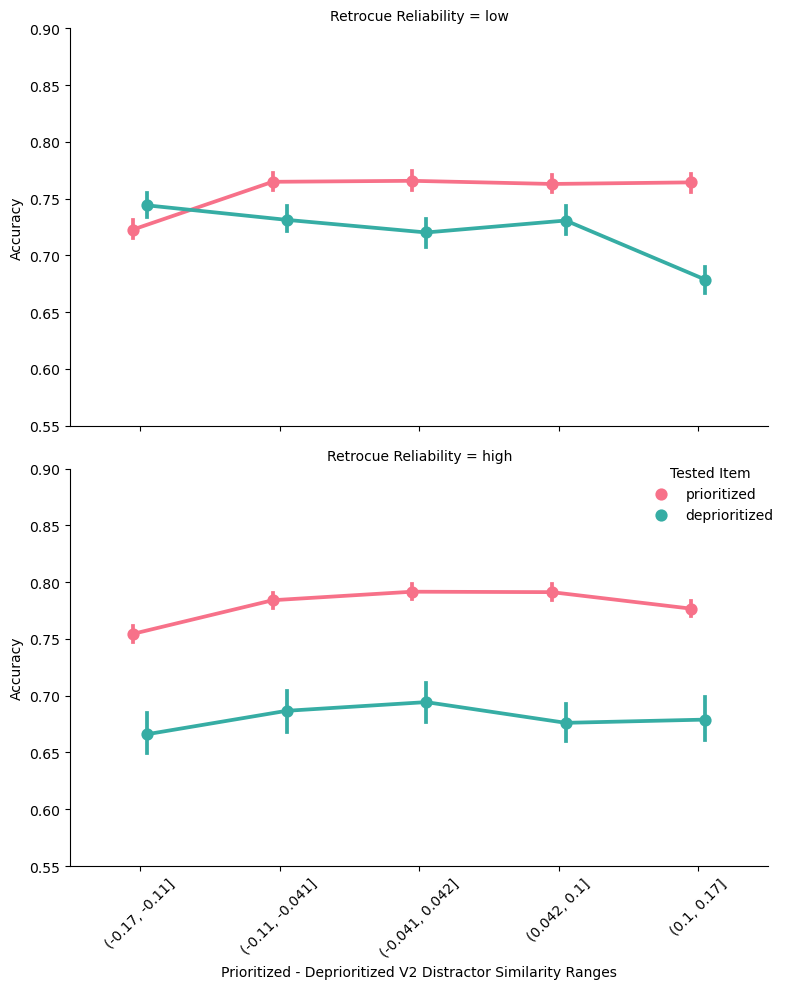

In [39]:


g = sns.catplot(
    x='Prioritized - Deprioritized V2 Distractor Similarity Ranges',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',  # Use 'row' instead of 'col'
    aspect=1.3,
    row_order = ['low', 'high'],
    dodge=0.1,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.55, 0.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_axis_labels("Prioritized - Deprioritized V2 Distractor Similarity Ranges", "Accuracy")
plt.tight_layout()
plt.show()

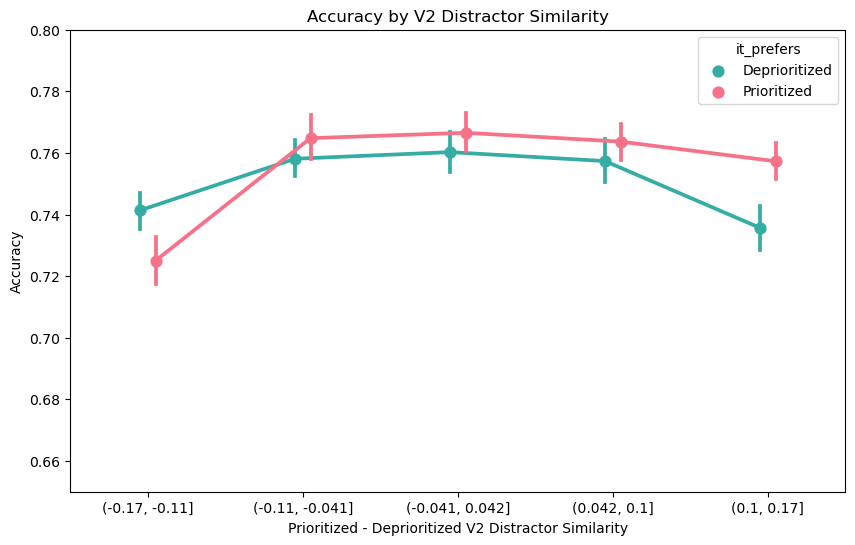

In [40]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='V2_diff_binned',
    y='Accuracy',
    hue = 'it_prefers',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.1,
    palette=palette,  # Use the single-color palette
    data=df
)
plt.ylim(0.65, 0.8)
plt.ylabel('Accuracy')
plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity')
plt.title('Accuracy by V2 Distractor Similarity')
plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/2612231446.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(44.99652777777777, 0.5, 'Accuracy')

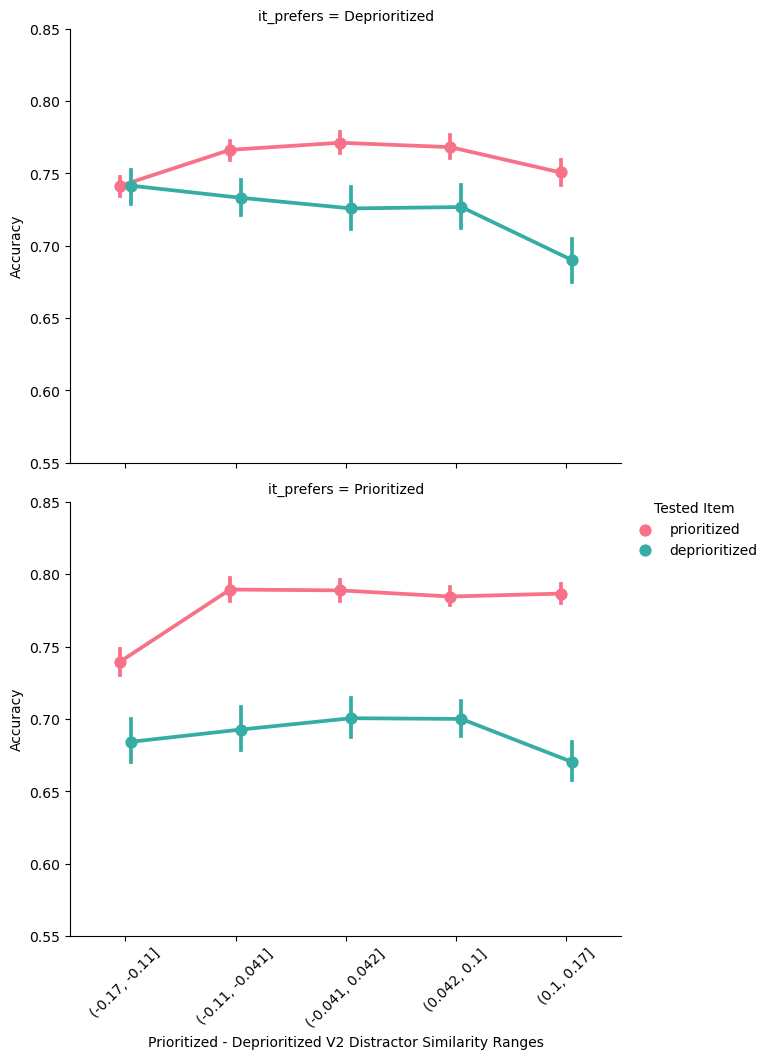

In [41]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized V2 Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            row = 'it_prefers',
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

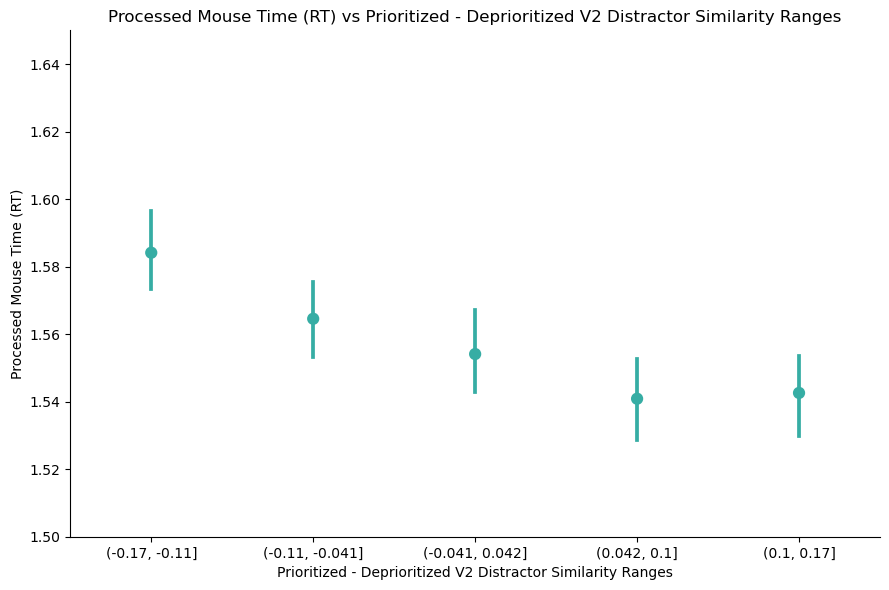

In [42]:
g = sns.catplot(x='Prioritized - Deprioritized V2 Distractor Similarity Ranges', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.65))

plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Prioritized - Deprioritized V2 Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

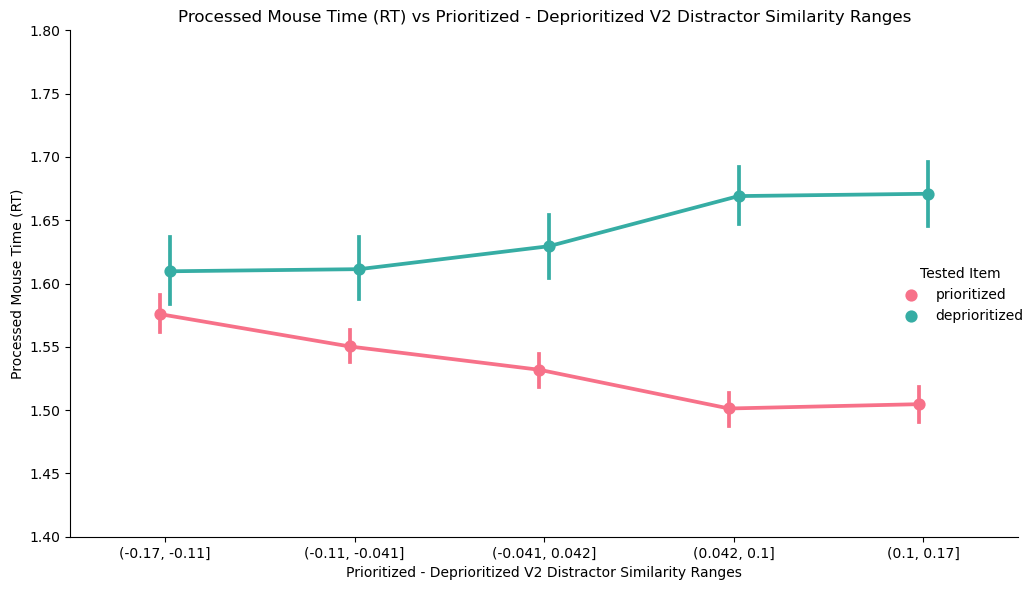

In [43]:
g = sns.catplot(x='Prioritized - Deprioritized V2 Distractor Similarity Ranges', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.8))

plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Prioritized - Deprioritized V2 Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

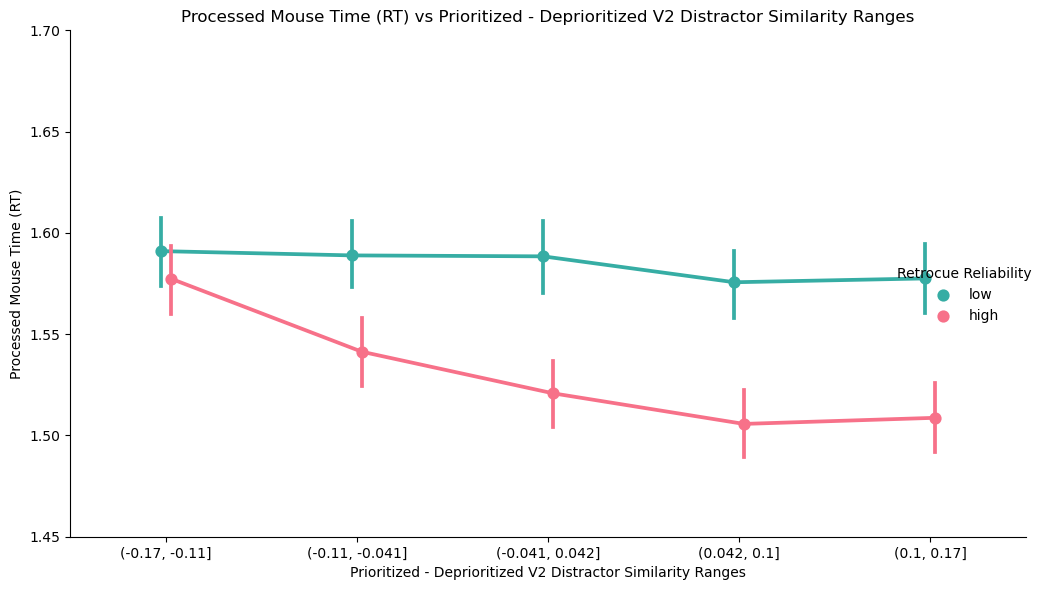

In [44]:
g = sns.catplot(x='Prioritized - Deprioritized V2 Distractor Similarity Ranges', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.45, 1.7))

plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Prioritized - Deprioritized V2 Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

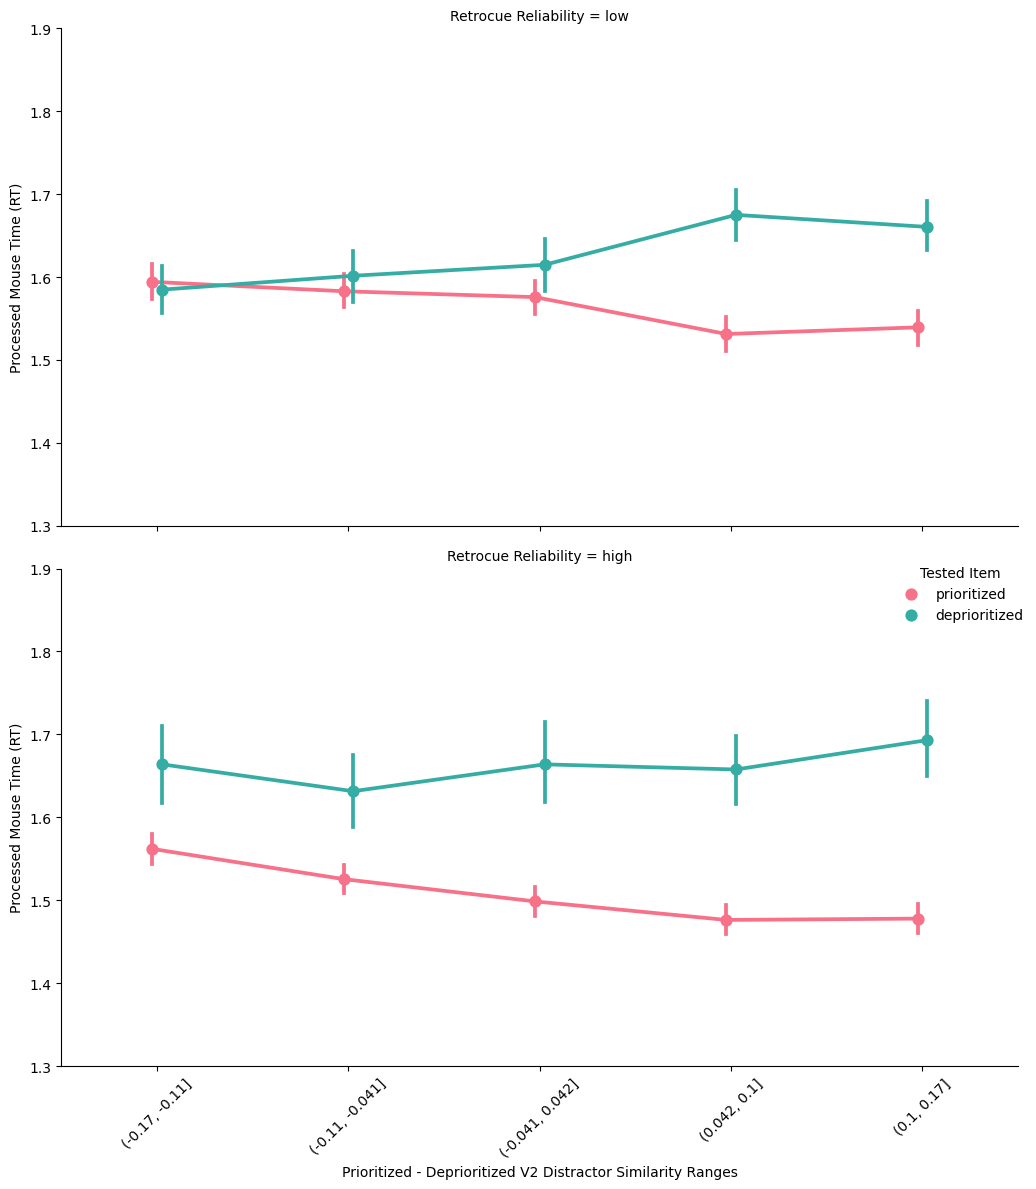

In [45]:
g = sns.catplot(
    x='Prioritized - Deprioritized V2 Distractor Similarity Ranges',
    y='analysis_rt',
    row='Retrocue Reliability',
    hue='Tested Item',  # Use 'row' instead of 'col'
    kind='point',
    row_order = ['low', 'high'],
    data=df_correct,
    dodge=True,
    height=6,
    aspect=1.5,
    palette=palette[::-1]  # Use the reversed color order
)
g.set(ylim=(1.3, 1.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Prioritized - Deprioritized V2 Distractor Similarity Ranges')
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set the y-axis label for all plots
g.set_axis_labels('Prioritized - Deprioritized V2 Distractor Similarity Ranges', 'Processed Mouse Time (RT)')

plt.tight_layout()
plt.show()

In [46]:
df['v2_prefers']

0          Prioritized
1          Prioritized
2          Prioritized
3        Deprioritized
4        Deprioritized
             ...      
40195      Prioritized
40196      Prioritized
40197    Deprioritized
40198      Prioritized
40199    Deprioritized
Name: v2_prefers, Length: 40200, dtype: object

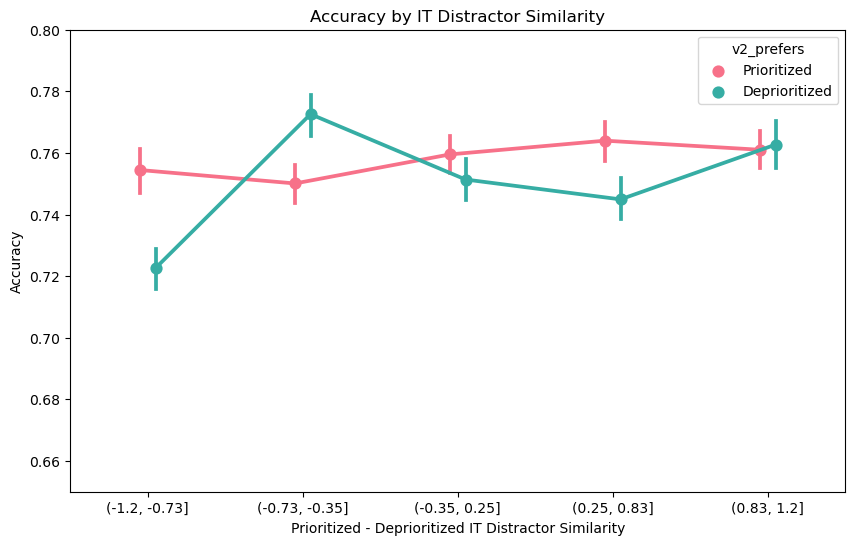

In [47]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='IT_diff_binned',
    y='Accuracy',
    hue = 'v2_prefers',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.1,
    palette=palette[::-1],  # Use the single-color palette
    data=df
)
plt.ylim(0.65, 0.8)
plt.ylabel('Accuracy')
plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity')
plt.title('Accuracy by IT Distractor Similarity')
plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/1380626430.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(46.88246527777777, 0.5, 'Accuracy')

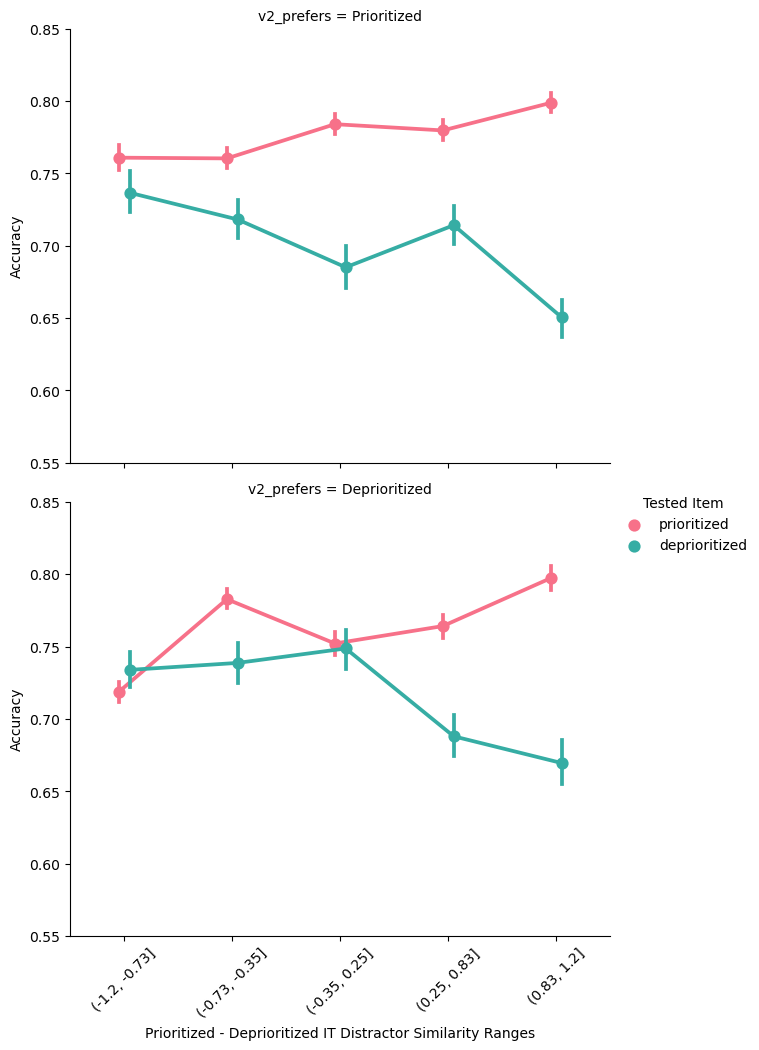

In [48]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized IT Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            row = 'v2_prefers',
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

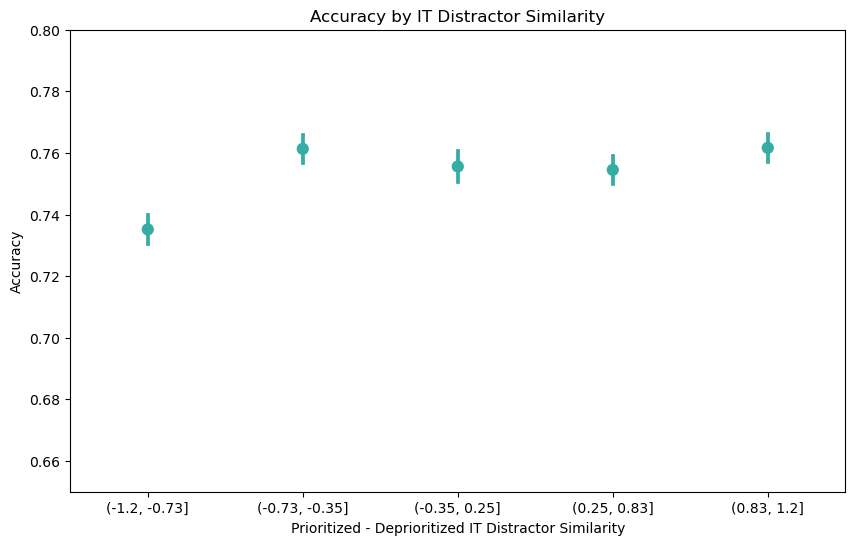

In [49]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='IT_diff_binned',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.1,
    palette=single_color_palette,  # Use the single-color palette
    data=df
)
plt.ylim(0.65, 0.8)
plt.ylabel('Accuracy')
plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity')
plt.title('Accuracy by IT Distractor Similarity')
plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/2852279418.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(44.99652777777777, 0.5, 'Accuracy')

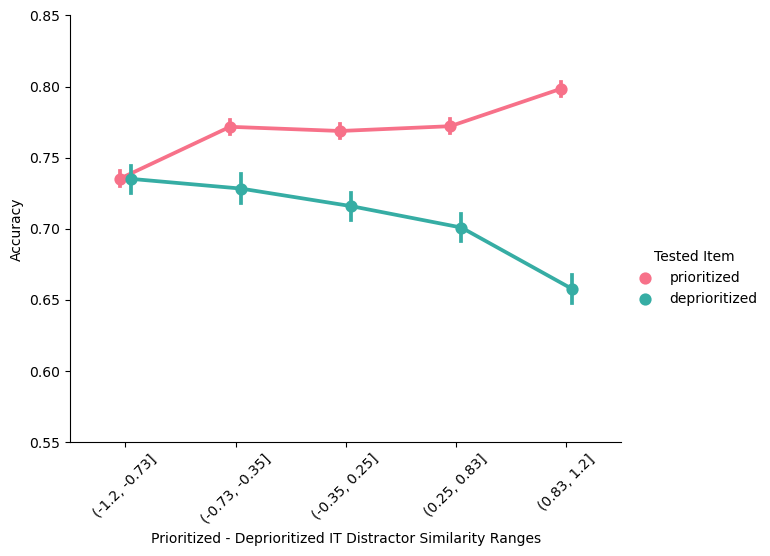

In [50]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized IT Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
#             row = 'v2_prefers',
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/790103852.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(45.877985517568845, 0.5, 'Accuracy')

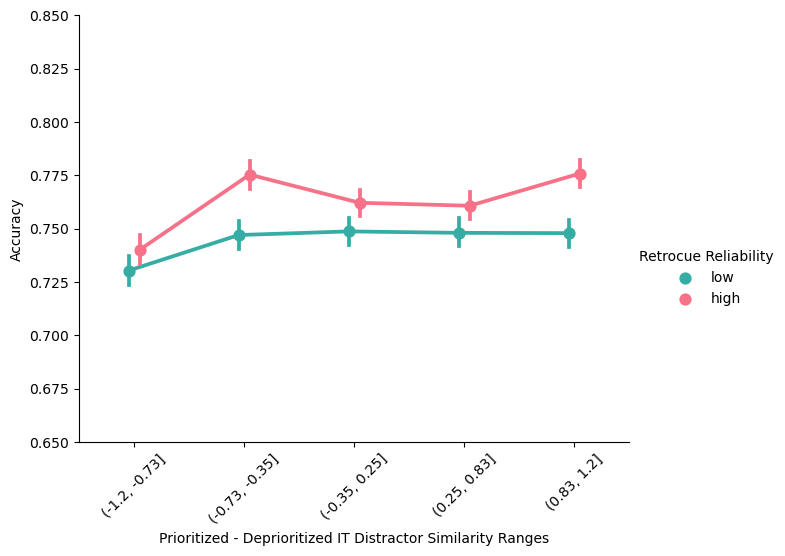

In [51]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized IT Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Retrocue Reliability',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette,  # Reverse the color order
            data = df)
g.set(ylim=(0.65, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/400314580.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


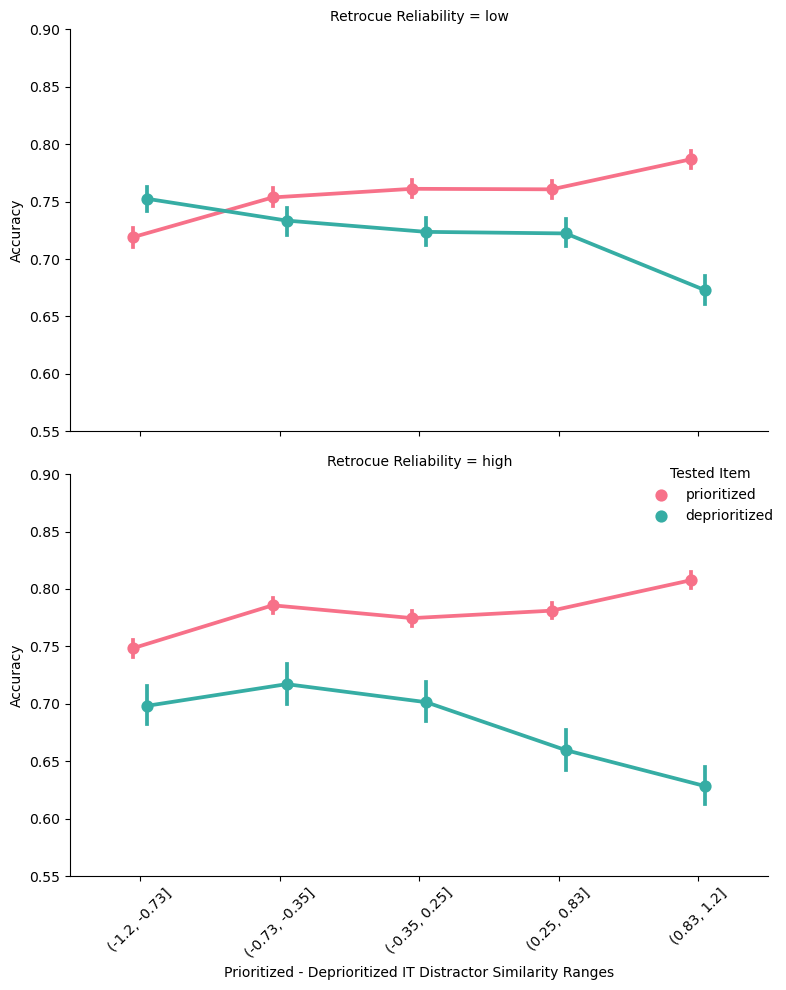

In [52]:


g = sns.catplot(
    x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',  # Use 'row' instead of 'col'
    aspect=1.3,
    row_order = ['low', 'high'],
    dodge=0.1,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.55, 0.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_axis_labels("Prioritized - Deprioritized IT Distractor Similarity Ranges", "Accuracy")
plt.tight_layout()
plt.show()

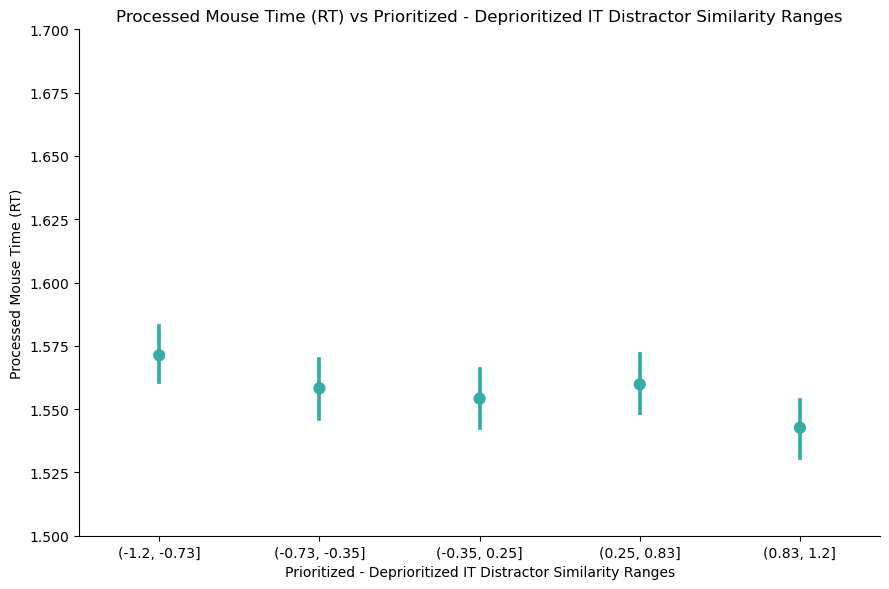

In [53]:
g = sns.catplot(x='Prioritized - Deprioritized IT Distractor Similarity Ranges', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.7))

plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Prioritized - Deprioritized IT Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

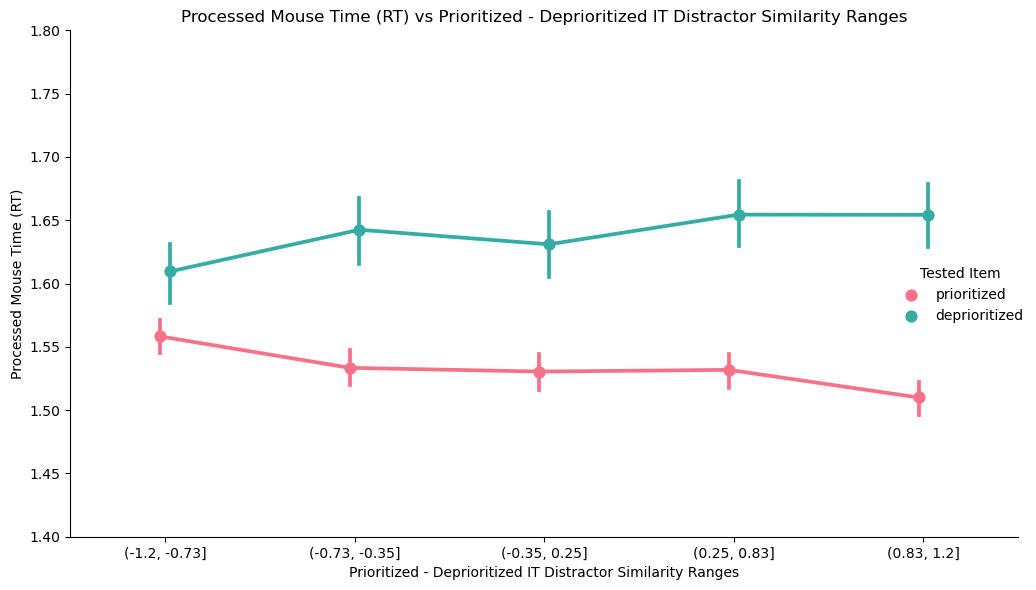

In [54]:
g = sns.catplot(x='Prioritized - Deprioritized IT Distractor Similarity Ranges', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.8))

plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Prioritized - Deprioritized IT Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

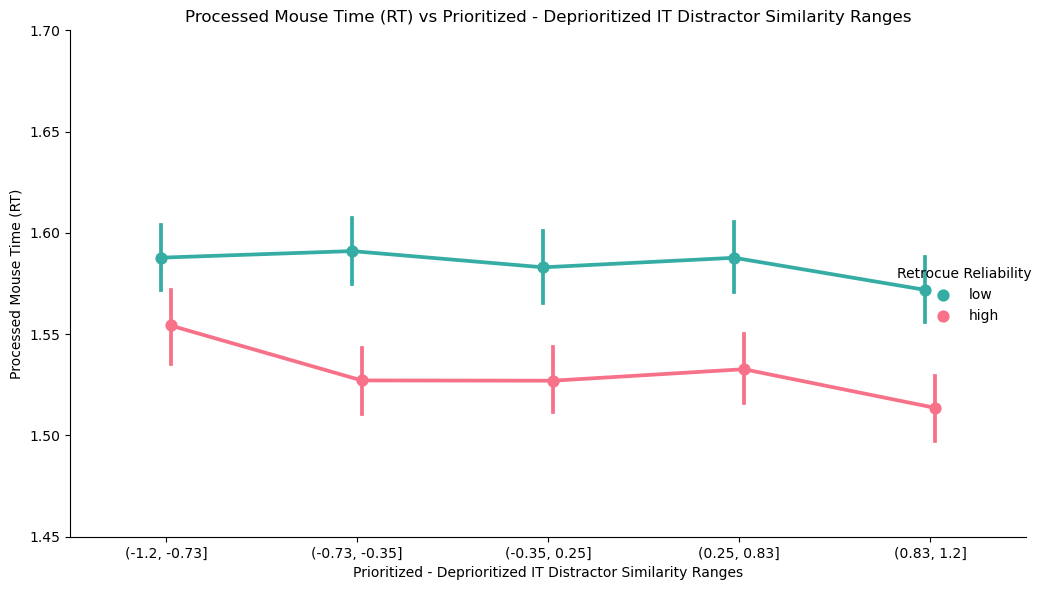

In [55]:
g = sns.catplot(x='Prioritized - Deprioritized IT Distractor Similarity Ranges', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.45, 1.7))

plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Prioritized - Deprioritized IT Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

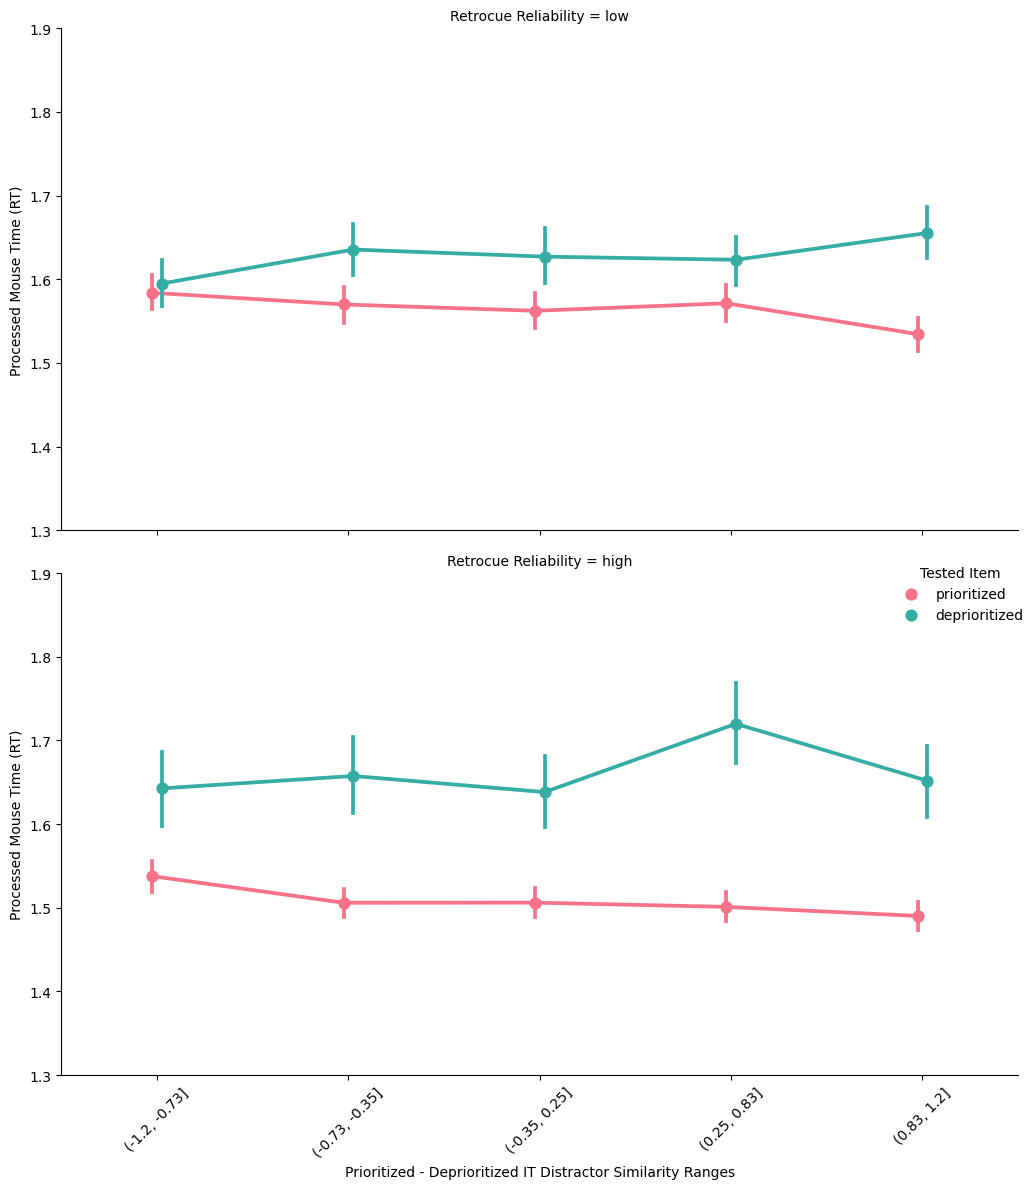

In [56]:
g = sns.catplot(
    x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
    y='analysis_rt',
    row='Retrocue Reliability',
    hue='Tested Item',  # Use 'row' instead of 'col'
    kind='point',
    row_order = ['low', 'high'],
    data=df_correct,
    dodge=True,
    height=6,
    aspect=1.5,
    palette=palette[::-1] # Use the reversed color order
)
g.set(ylim=(1.3, 1.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Prioritized - Deprioritized IT Distractor Similarity Ranges')
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set the y-axis label for all plots
g.set_axis_labels('Prioritized - Deprioritized IT Distractor Similarity Ranges', 'Processed Mouse Time (RT)')

plt.tight_layout()
plt.show()

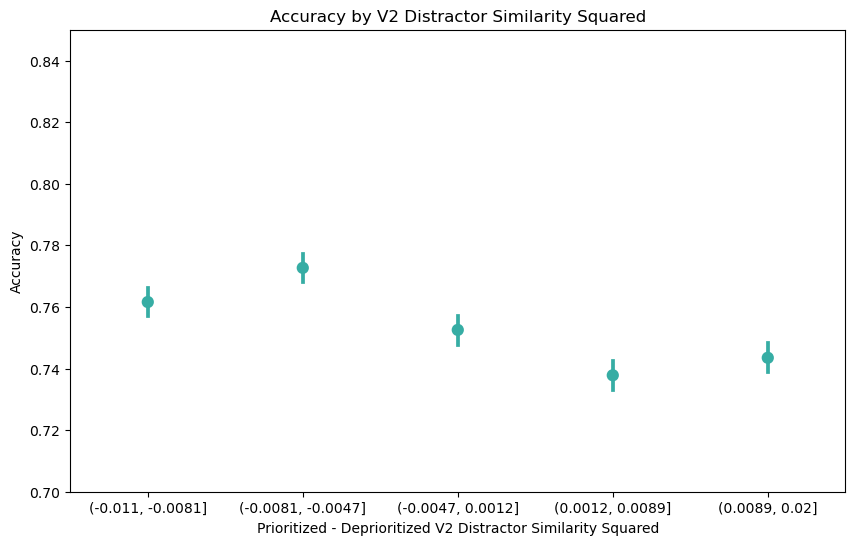

In [57]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='V2_diff_binned_sq',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.1,
    palette=single_color_palette,  # Use the single-color palette
    data=df
)
plt.ylim(0.7, 0.85)
plt.ylabel('Accuracy')
plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity Squared')
plt.title('Accuracy by V2 Distractor Similarity Squared')
plt.show()




/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/3699410078.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(44.99652777777777, 0.5, 'Accuracy')

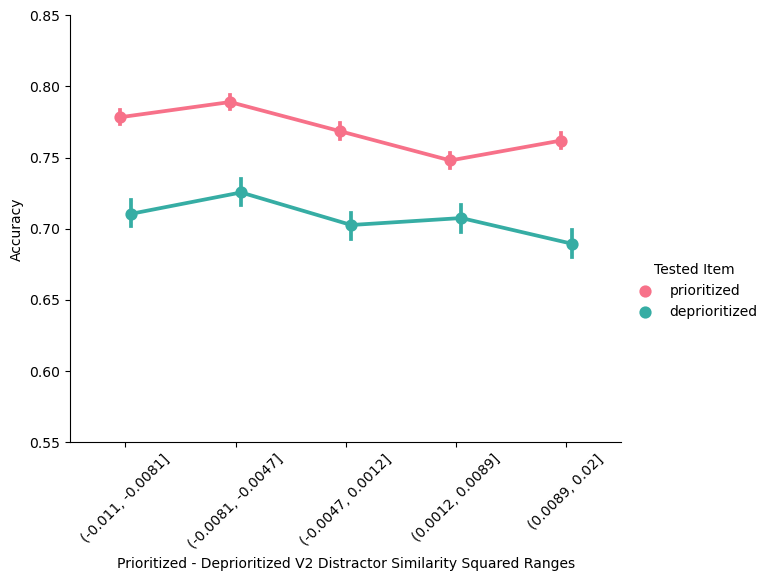

In [58]:

g = sns.catplot(
            x = 'Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = sns.color_palette("husl", n_colors=2),  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')



/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/3775300540.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(45.877985517568845, 0.5, 'Accuracy')

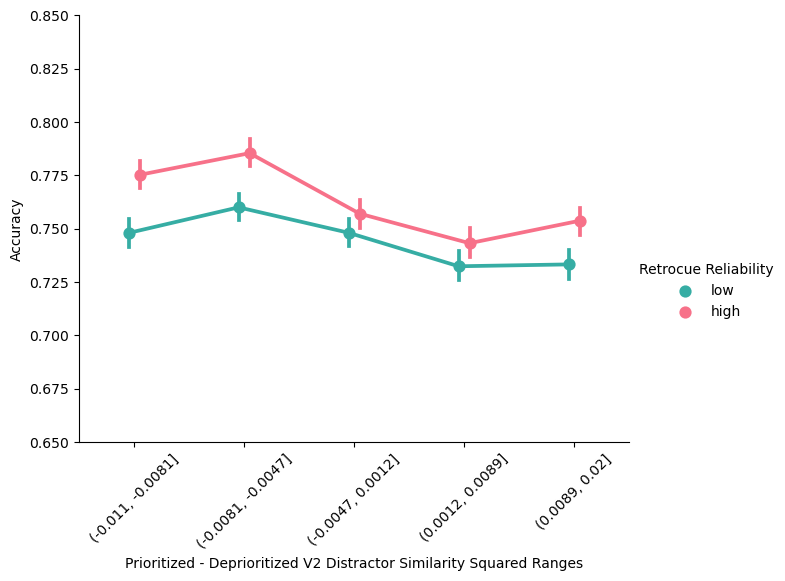

In [59]:

g = sns.catplot(
            x = 'Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Retrocue Reliability',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette,  # Reverse the color order
            data = df)
g.set(ylim=(0.65, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/2709325249.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


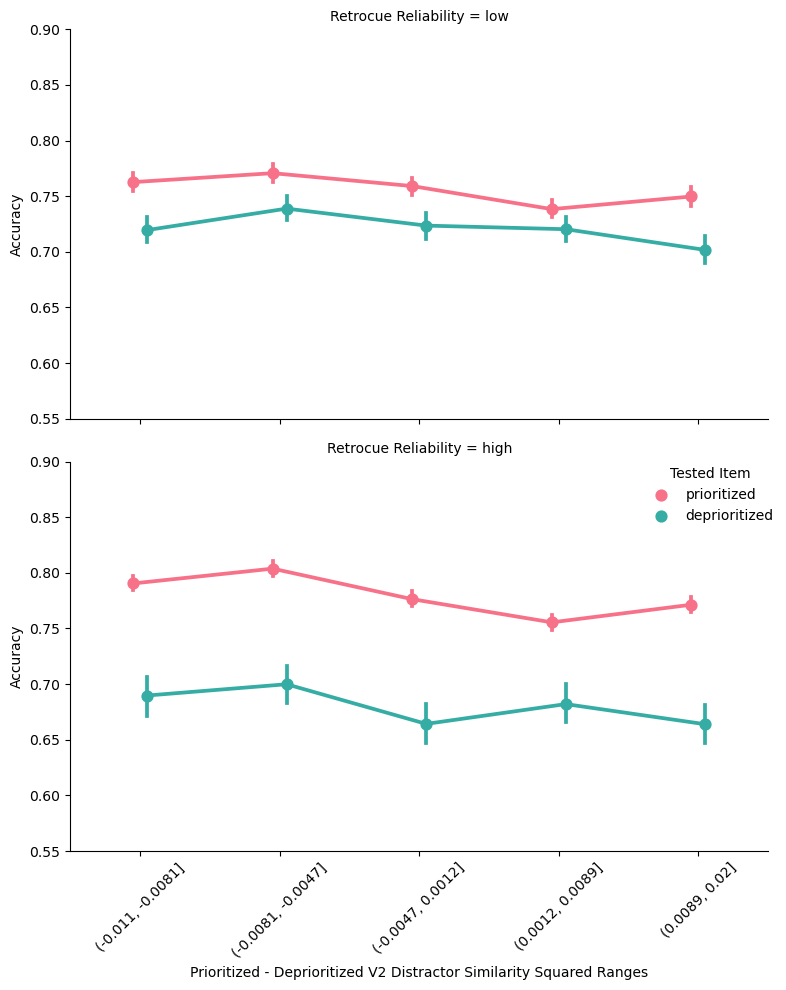

In [60]:


g = sns.catplot(
    x='Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',  # Use 'row' instead of 'col'
    aspect=1.3,
    row_order = ['low', 'high'],
    dodge=0.1,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.55, 0.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_axis_labels("Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges", "Accuracy")
plt.tight_layout()
plt.show()

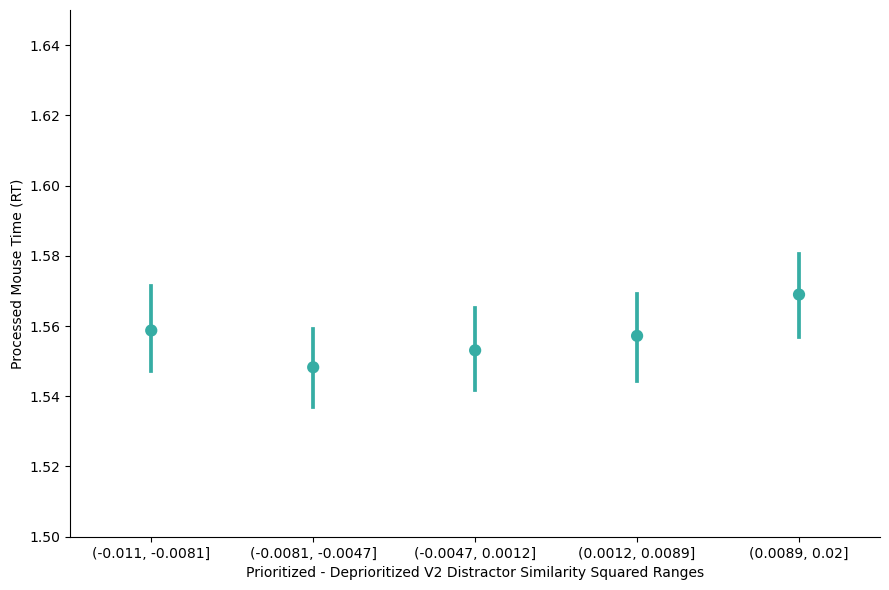

In [61]:
g = sns.catplot(x='Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.65))

plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nSquared Ranges')
plt.tight_layout()
plt.show()



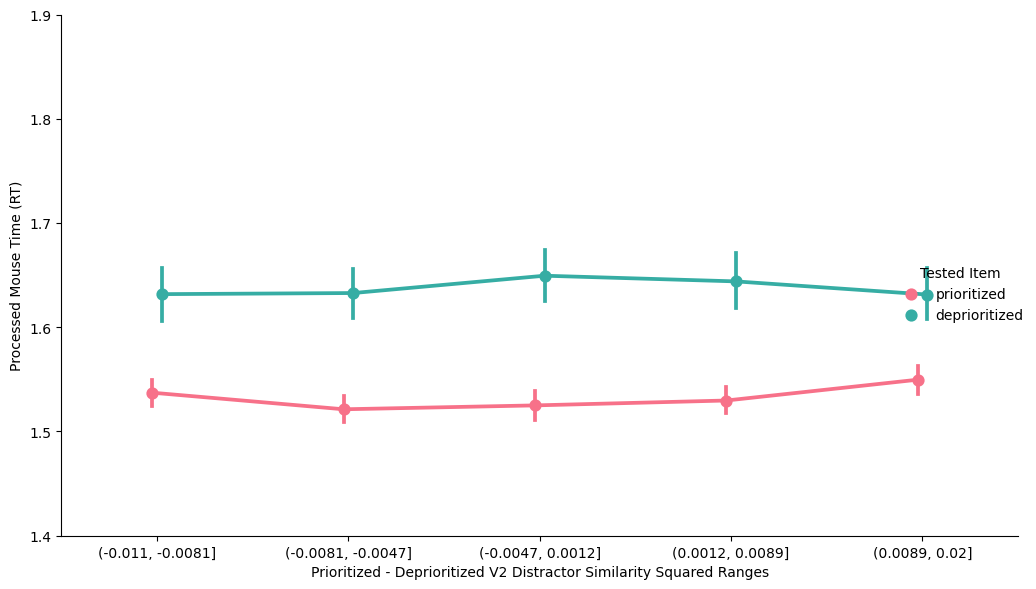

In [62]:
g = sns.catplot(x='Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.9))

plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()



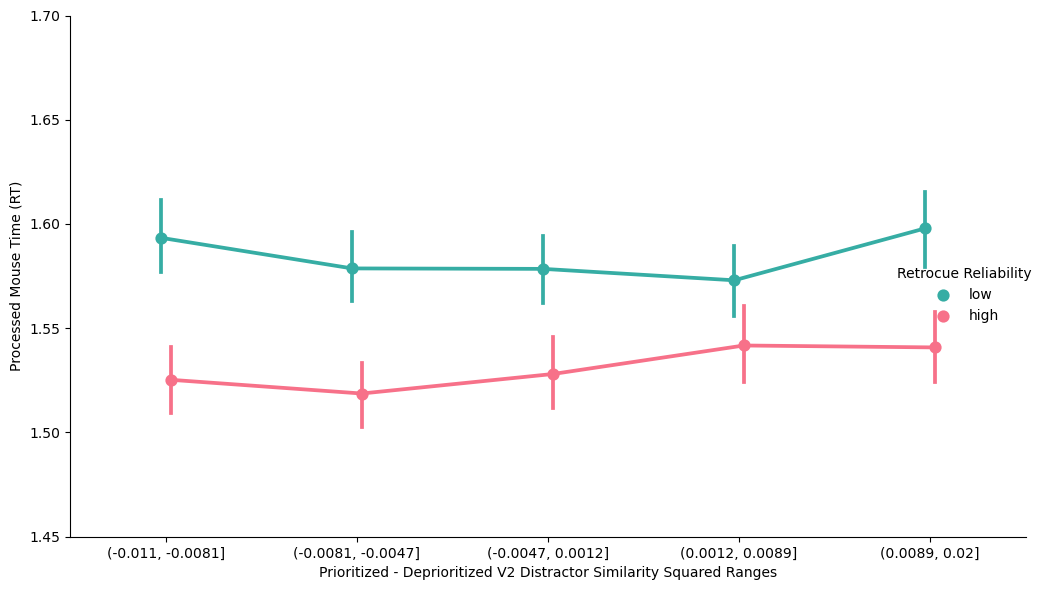

In [63]:
g = sns.catplot(x='Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.45, 1.7))

plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges')
plt.tight_layout()
plt.show()



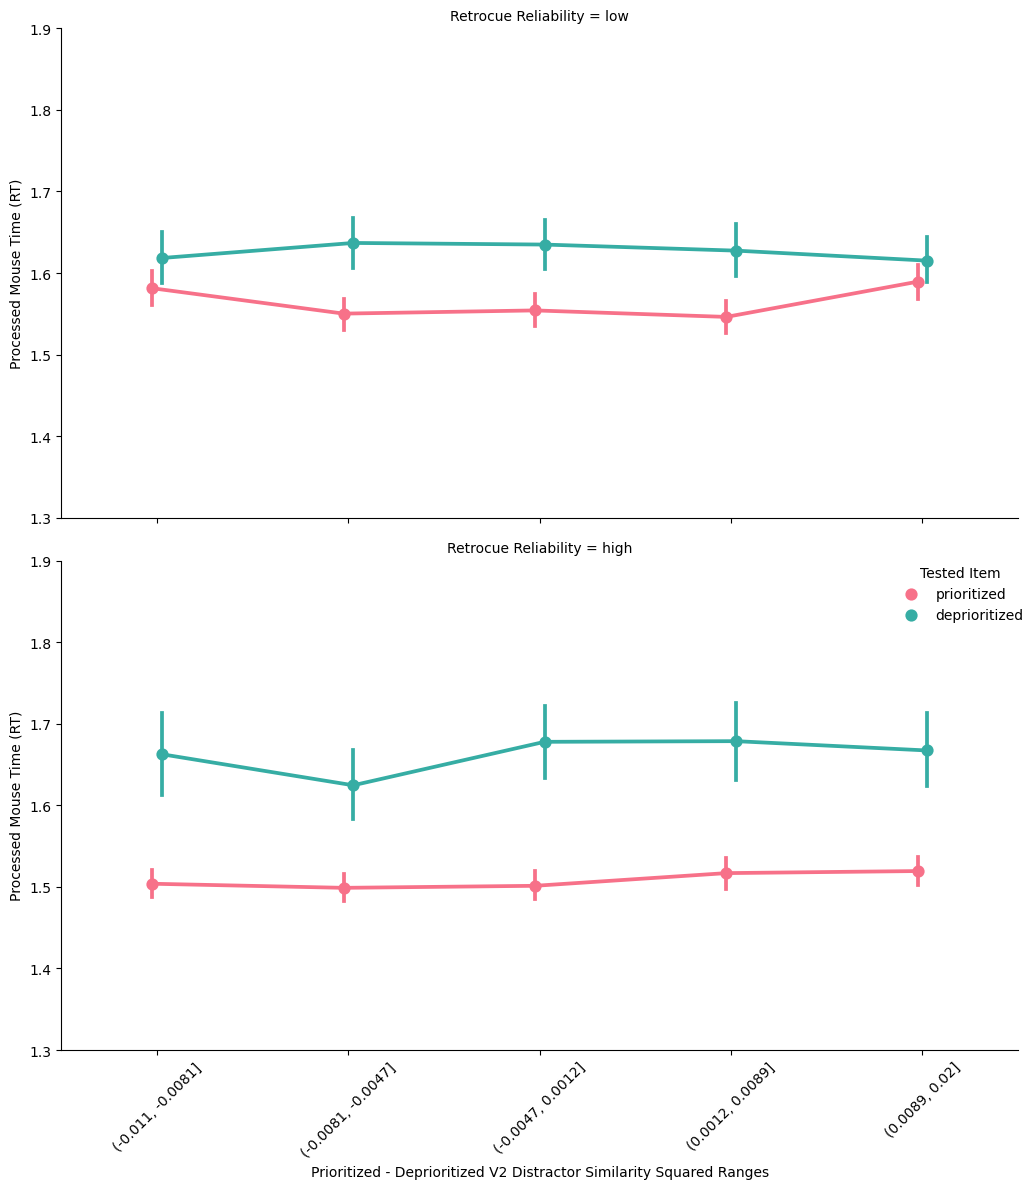

In [64]:
g = sns.catplot(
    x='Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges',
    y='analysis_rt',
    row='Retrocue Reliability',
    hue='Tested Item',  # Use 'row' instead of 'col'
    kind='point',
    row_order = ['low', 'high'], 
    data=df_correct,
    dodge=True,
    height=6,
    aspect=1.5,
    palette=palette[::-1]  # Use the reversed color order
)
g.set(ylim=(1.3, 1.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges')
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set the y-axis label for all plots
g.set_axis_labels('Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges', 'Processed Mouse Time (RT)')

plt.tight_layout()
plt.show()



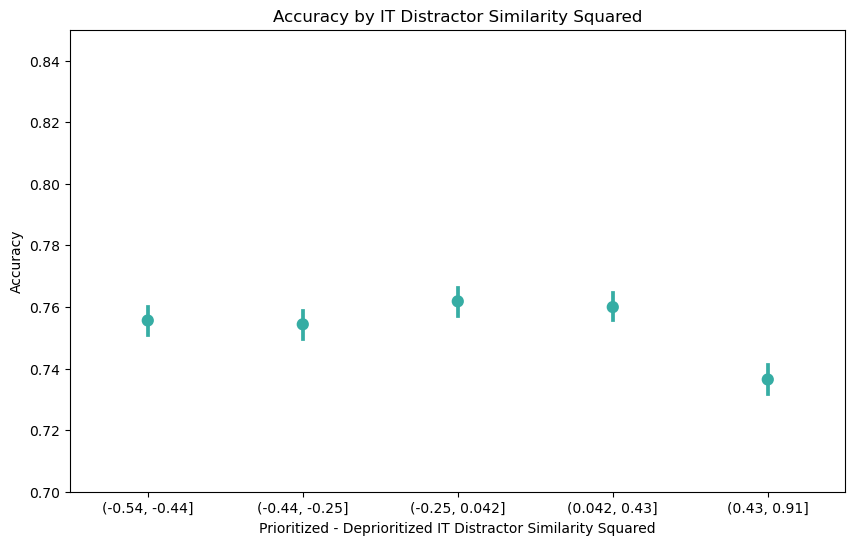

In [65]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='IT_diff_binned_sq',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.1,
    palette=single_color_palette,  # Use the single-color palette
    data=df
)
plt.ylim(0.7, 0.85)
plt.ylabel('Accuracy')
plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity Squared')
plt.title('Accuracy by IT Distractor Similarity Squared')
plt.show()


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/3125865.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(44.99652777777777, 0.5, 'Accuracy')

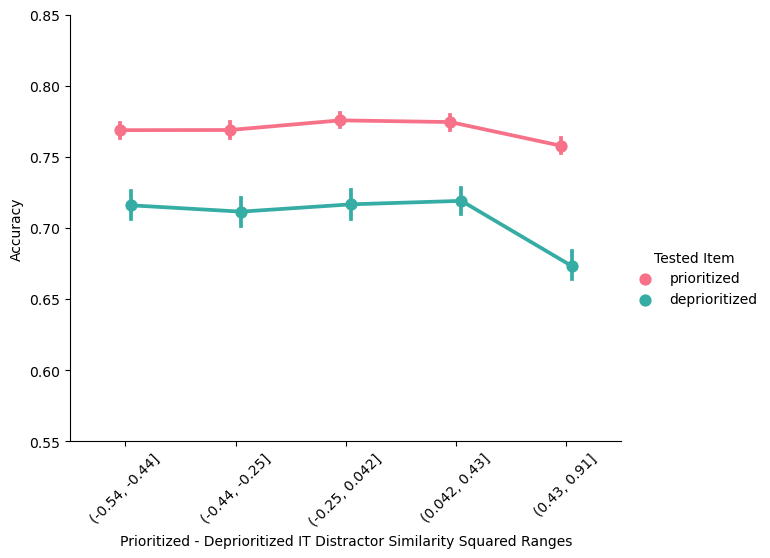

In [66]:


g = sns.catplot(
            x = 'Prioritized - Deprioritized IT Distractor Similarity Squared Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = sns.color_palette("husl", n_colors=2),  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')



/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/103419771.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(45.877985517568845, 0.5, 'Accuracy')

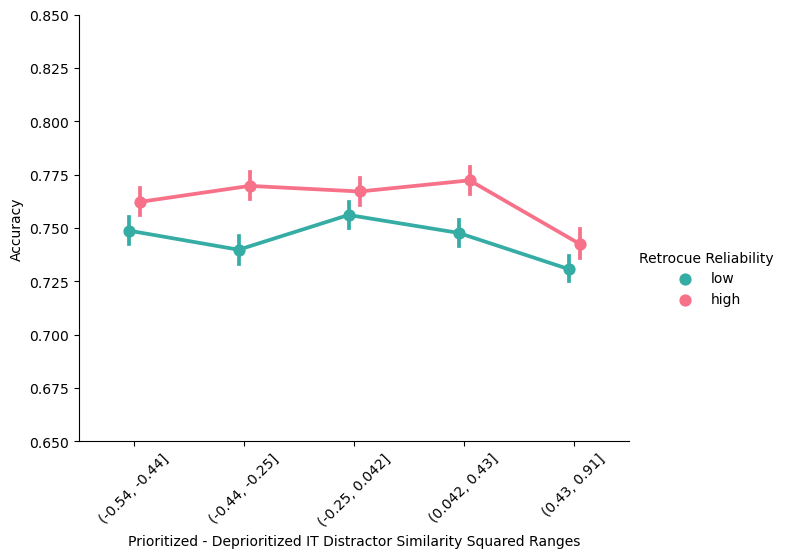

In [67]:

g = sns.catplot(
            x = 'Prioritized - Deprioritized IT Distractor Similarity Squared Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Retrocue Reliability',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette,  # Reverse the color order
            data = df)
g.set(ylim=(0.65, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')



/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/603937276.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


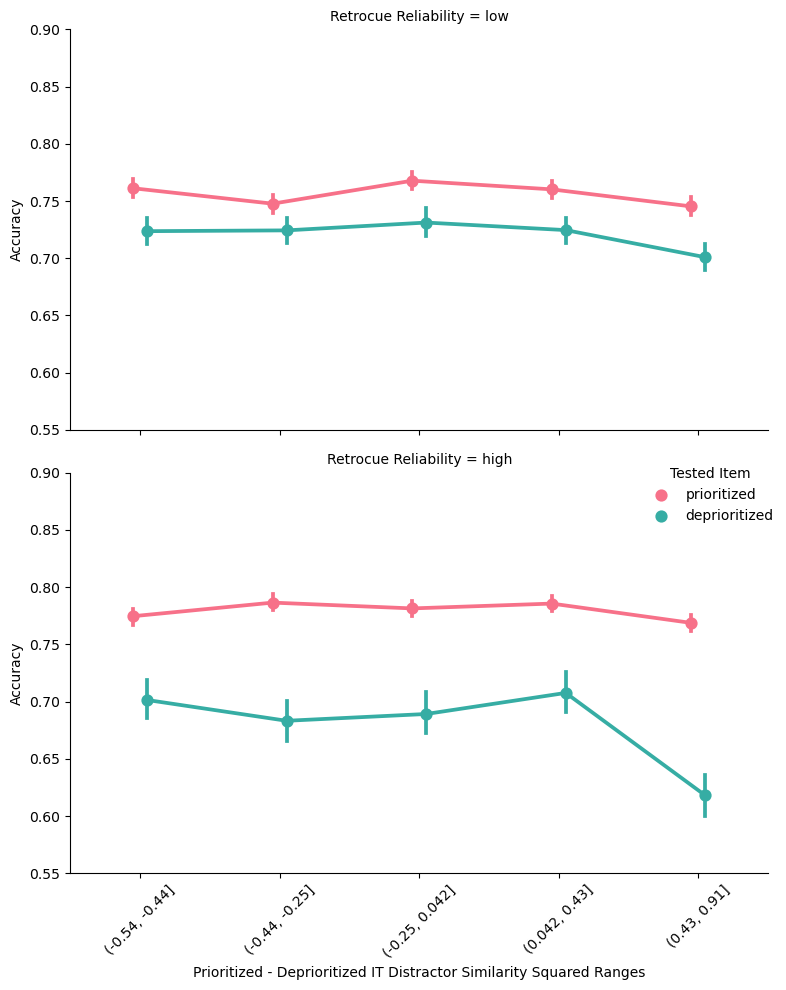

In [68]:

g = sns.catplot(
    x='Prioritized - Deprioritized IT Distractor Similarity Squared Ranges',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',  # Use 'row' instead of 'col'
    aspect=1.3,
    row_order = ['low', 'high'],
    dodge=0.1,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.55, 0.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_axis_labels("Prioritized - Deprioritized IT Distractor Similarity Squared Ranges", "Accuracy")
plt.tight_layout()
plt.show()

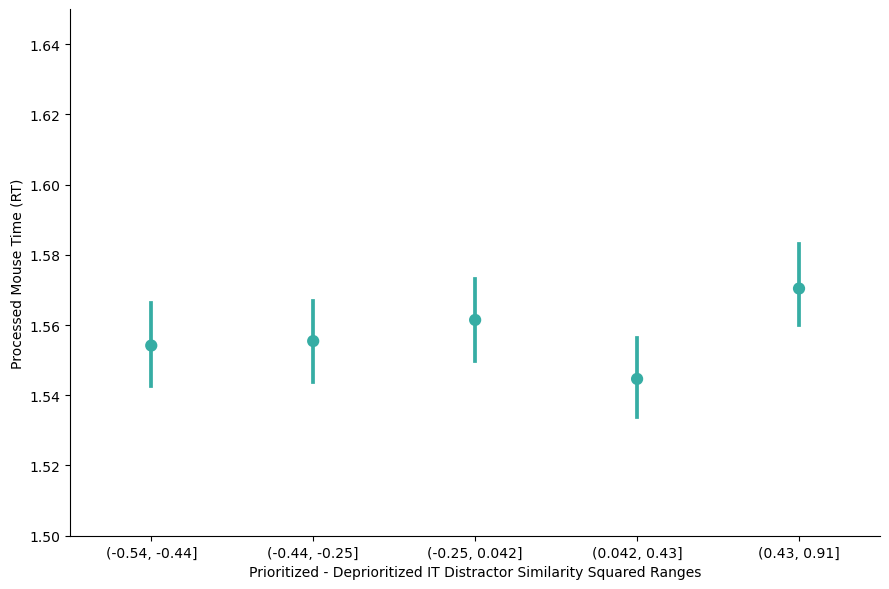

In [69]:
g = sns.catplot(x='Prioritized - Deprioritized IT Distractor Similarity Squared Ranges', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.65))

plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nSquared Ranges')
plt.tight_layout()
plt.show()


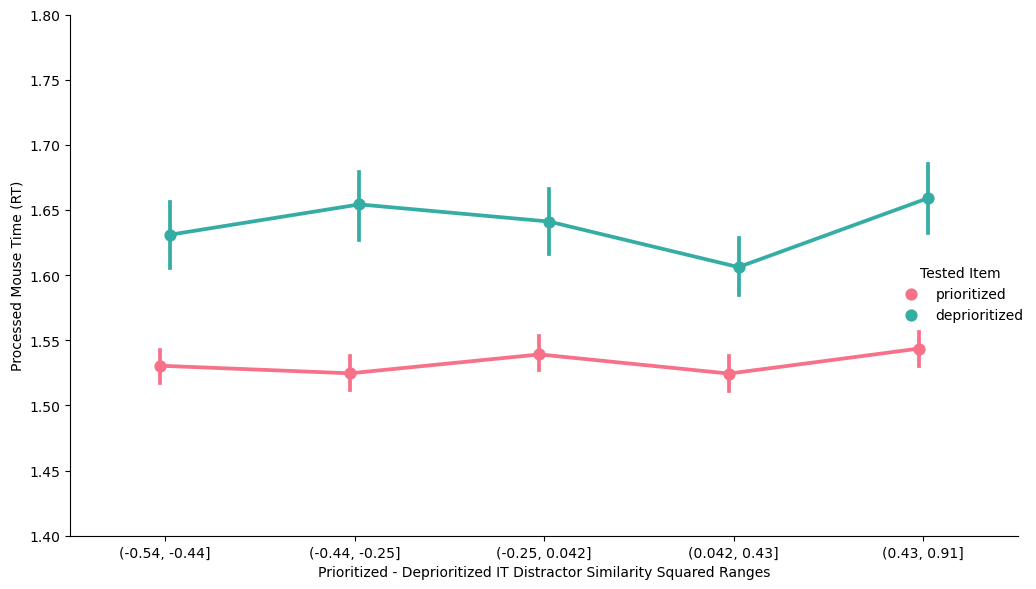

In [70]:

g = sns.catplot(x='Prioritized - Deprioritized IT Distractor Similarity Squared Ranges', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.8))

plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()



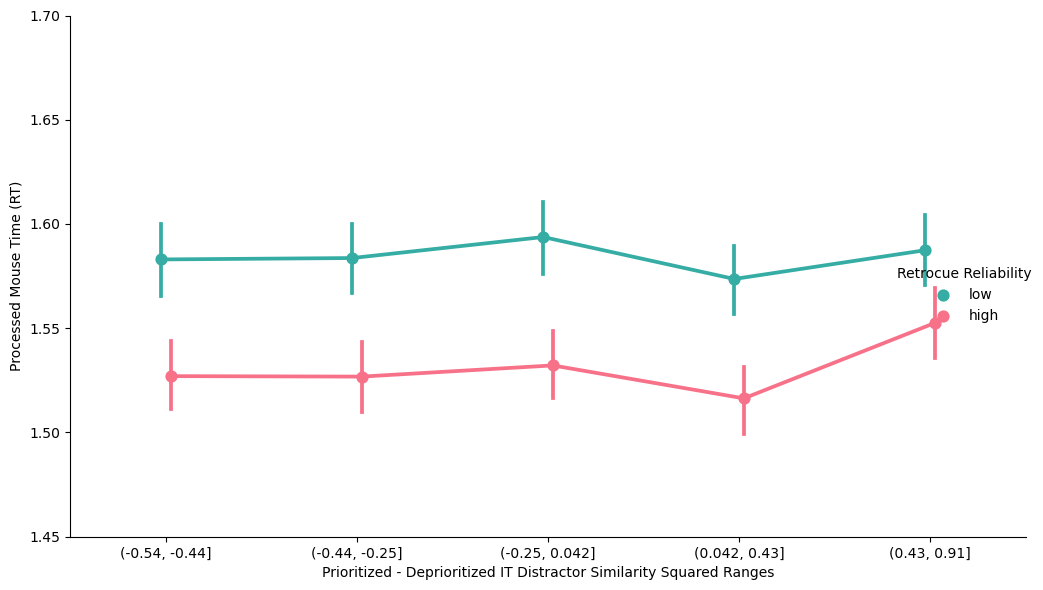

In [71]:

g = sns.catplot(x='Prioritized - Deprioritized IT Distractor Similarity Squared Ranges', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.45, 1.7))

plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges')
plt.tight_layout()
plt.show()



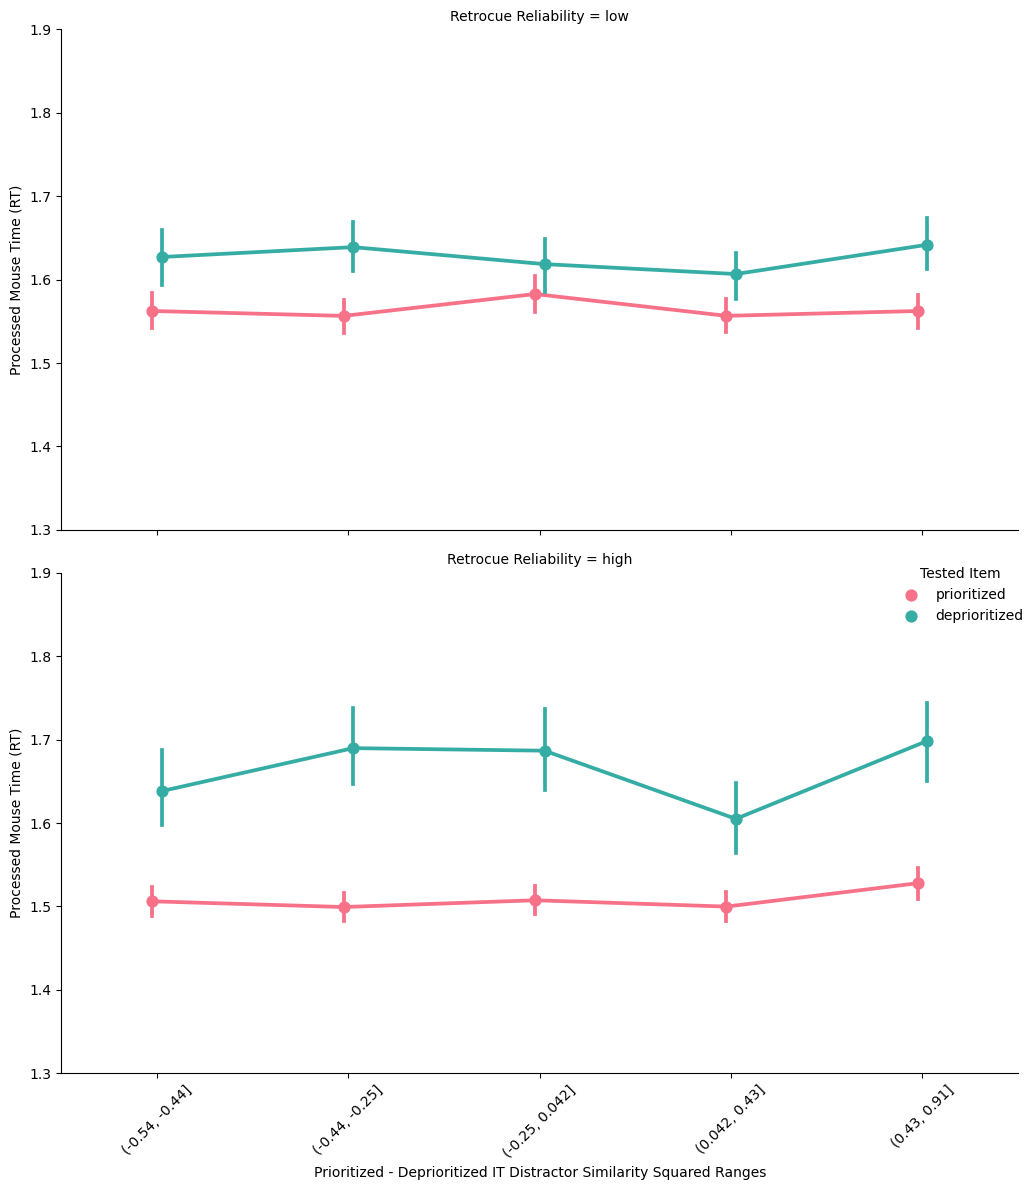

In [72]:
g = sns.catplot(
    x='Prioritized - Deprioritized IT Distractor Similarity Squared Ranges',
    y='analysis_rt',
    row='Retrocue Reliability',
    hue='Tested Item',  # Use 'row' instead of 'col'
    kind='point',
    row_order = ['low', 'high'],
    data=df_correct,
    dodge=True,
    height=6,
    aspect=1.5,
    palette=palette[::-1]  # Use the reversed color order
)
g.set(ylim=(1.3, 1.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Prioritized - Deprioritized IT Distractor Similarity Squared Ranges')
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set the y-axis label for all plots
g.set_axis_labels('Prioritized - Deprioritized IT Distractor Similarity Squared Ranges', 'Processed Mouse Time (RT)')

plt.tight_layout()
plt.show()


In [73]:
len(set(df['participant']))

134

In [74]:
df.to_csv('old_dataframe.csv', index=False)  # Set index=False to avoid saving row indices


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/3730263845.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(45.21367521367522, 0.5, 'Accuracy')

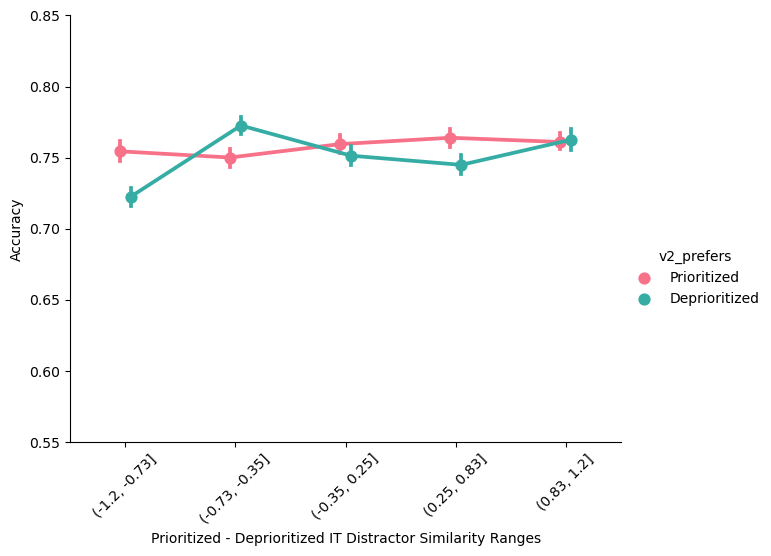

In [75]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized IT Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'v2_prefers',
#             hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/1380626430.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(46.88246527777777, 0.5, 'Accuracy')

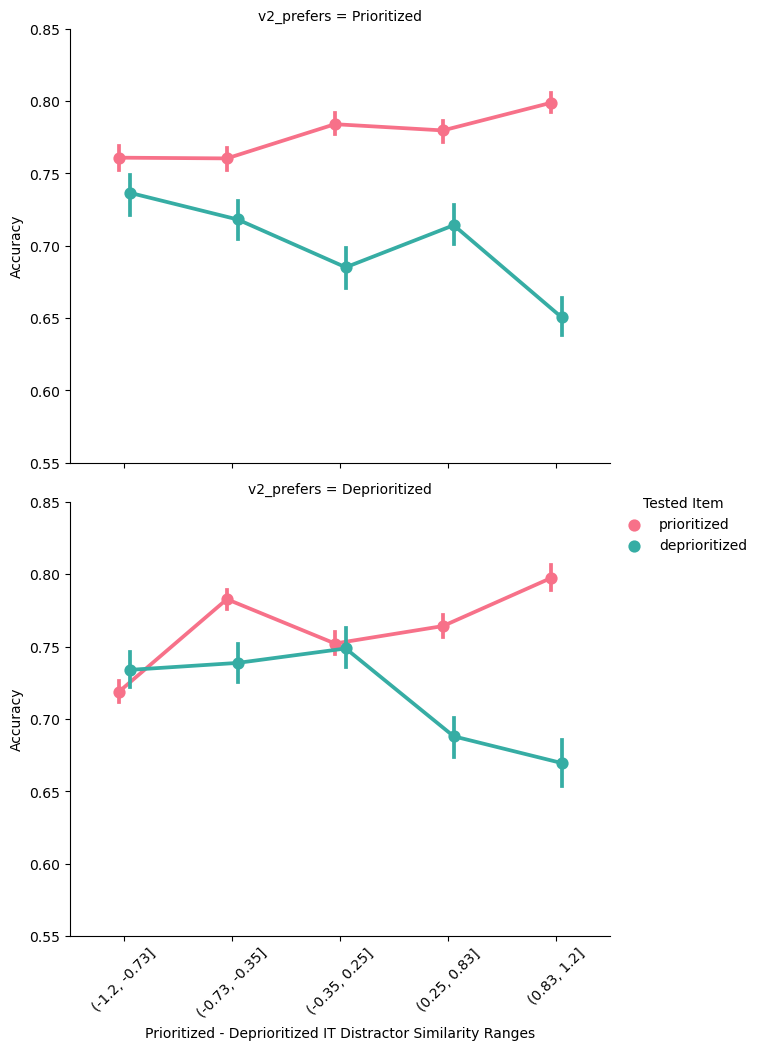

In [76]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized IT Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            row = 'v2_prefers',
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/1772617952.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(45.21367521367522, 0.5, 'Accuracy')

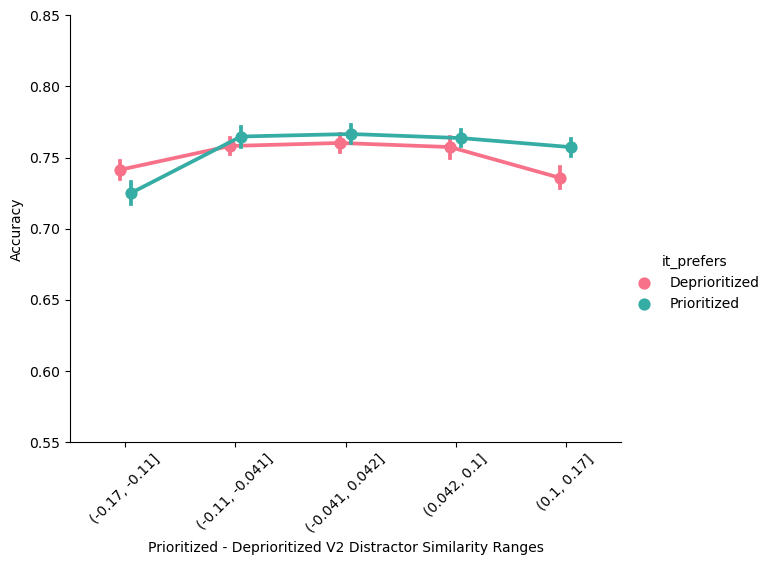

In [77]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized V2 Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'it_prefers',
#             hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/2612231446.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(44.99652777777777, 0.5, 'Accuracy')

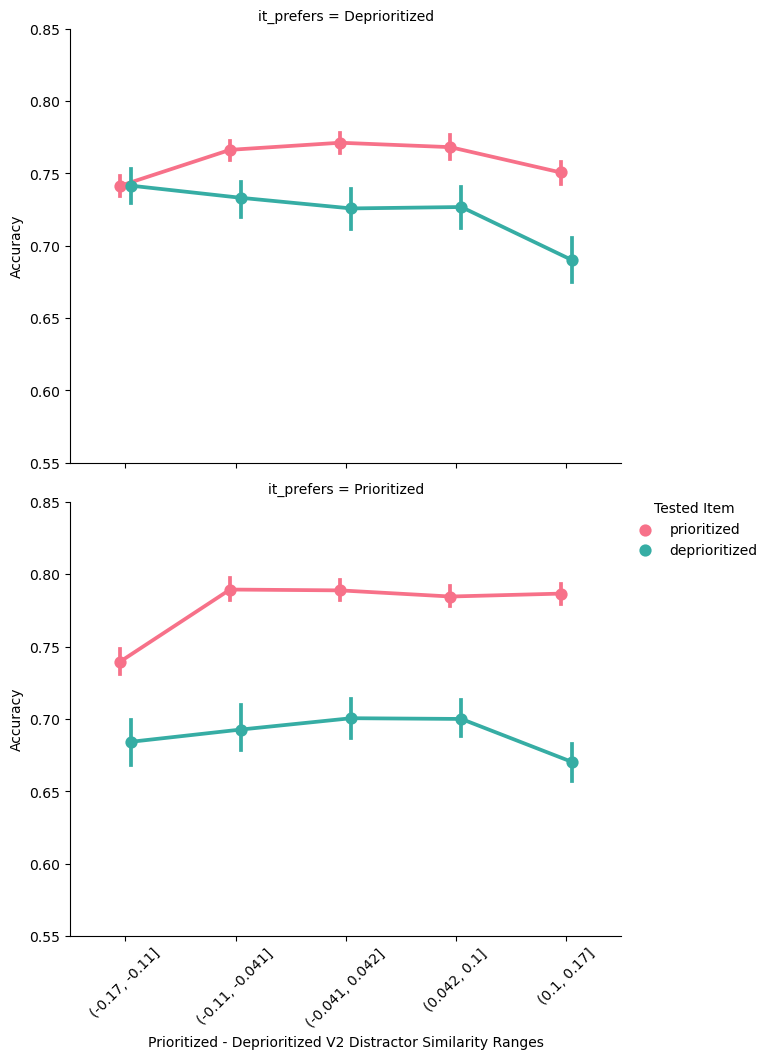

In [78]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized V2 Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            row = 'it_prefers',
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/2051032623.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


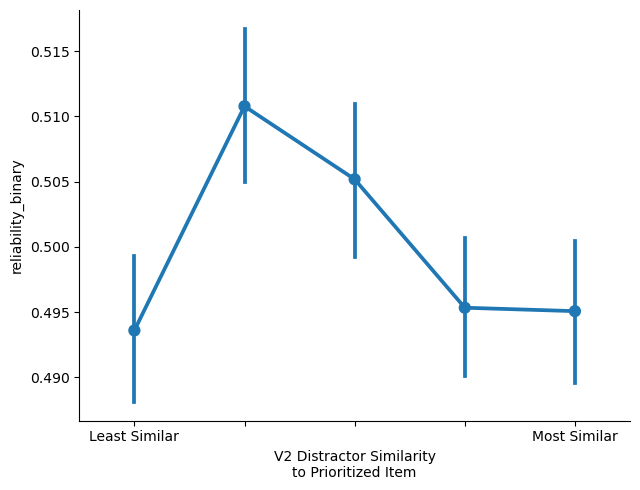

In [79]:

g = sns.catplot(
    x='V2 Distractor Similarity\nto Prioritized Item',
    y='reliability_binary',
    ci=68,
#     hue='Tested Item',
#     row='Retrocue Reliability',  # Use 'row' instead of 'col' to arrange plots vertically
    aspect=1.3,
    dodge=0.5,
    kind='point',
    row_order = ['low', 'high'],
#     palette=palette,  # Reverse the color order
    data=df)


plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_63065/802395013.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


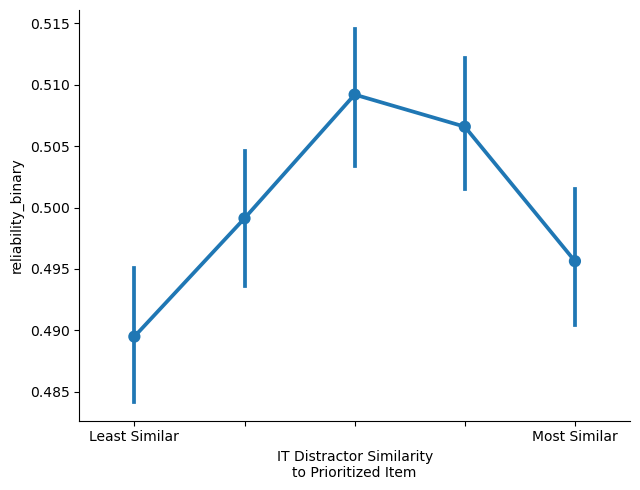

In [80]:

g = sns.catplot(
    x='IT Distractor Similarity\nto Prioritized Item',
    y='reliability_binary',
    ci=68,
#     hue='Tested Item',
#     row='Retrocue Reliability',  # Use 'row' instead of 'col' to arrange plots vertically
    aspect=1.3,
    dodge=0.5,
    kind='point',
    row_order = ['low', 'high'],
#     palette=palette,  # Reverse the color order
    data=df)


plt.show()

In [81]:
md = smf.glm(
    "resp_correct ~ it_sim_dis_diff*reliability*validity \
        + v2_sim_dis_diff*reliability*validity",
    data=df,
    family=sm.families.Binomial()  
).fit()

# View the summary
md.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           resp_correct   No. Observations:                40200
Model:                            GLM   Df Residuals:                    40188
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22297.
Date:                Mon, 04 Nov 2024   Deviance:                       44593.
Time:                        15:52:28   Pearson chi2:                 4.02e+04
No. Iterations:                     5   Pseudo R-squ. (CS):           0.007305
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                         1.7216      0.202      8.520      0.000       1.326       2.118
validity[T.valid]                                -1.1102      0.238     -4.666      0.000      -1.576      -0.644
it_sim_dis_diff                                  -0.0891      0.275     -0.325      0.745      -0.627       0.449
it_sim_dis_diff:validity[T.valid]                 0.3175      0.324      0.980      0.327      -0.317       0.952
reliability                                      -1.1536      0.277     -4.164      0.000      -1.697      -0.611
reliability:validity[T.valid]                     1.9390      0.322      6.013      0.000       1.307       2.571
it_sim_dis_diff:reliability                      -0.0882      0.377     -0.234      0.815      -0.827       0.650
it_sim_dis_diff:reliability:validity[T.valid]    -0.0518      0.439     -0.118      0.906      -0.913       0.809
v2_sim_dis_diff                                  -5.0719      2.068     -2.453      0.014      -9.125      -1.019
v2_sim_dis_diff:validity[T.valid]                 6.2580      2.439      2.565      0.010       1.477      11.039
v2_sim_dis_diff:reliability                       6.4875      2.835      2.288      0.022       0.931      12.044
v2_sim_dis_diff:reliability:validity[T.valid]    -7.4532      3.306     -2.255      0.024     -13.932      -0.974
=================================================================================================================
"""

In [82]:
md = sm.GEE.from_formula(
    "resp_correct ~ it_sim_dis_diff*reliability*validity + v2_sim_dis_diff*reliability*validity",
    groups="participant",
    data=df,
    family=sm.families.Binomial()
).fit()

In [83]:
md = smf.mixedlm("resp_correct ~ it_sim_dis_diff*reliability*validity + v2_sim_dis_diff*reliability*validity", df, 
                 groups=df["participant"]).fit()
md.summary()



<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
========================================================================================
Model:                      MixedLM           Dependent Variable:           resp_correct
No. Observations:           40200             Method:                       REML        
No. Groups:                 134               Scale:                        0.1681      
Min. group size:            300               Log-Likelihood:               -21448.8753 
Max. group size:            300               Converged:                    Yes         
Mean group size:            300.0                                                       
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      0.880    0.039 22.336 0.000  0.803  0.957
validity[T.valid]                             -0.218    0.044 -5.002 0.000 -0.304 -0.133
it_sim_dis_diff                               -0.000    0.051 -0.006 0.995 -0.101  0.100
it_sim_dis_diff:validity[T.valid]              0.050    0.059  0.843 0.399 -0.066  0.167
reliability                                   -0.239    0.052 -4.595 0.000 -0.341 -0.137
reliability:validity[T.valid]                  0.380    0.059  6.409 0.000  0.264  0.497
it_sim_dis_diff:reliability                   -0.042    0.071 -0.594 0.553 -0.181  0.097
it_sim_dis_diff:reliability:validity[T.valid]  0.005    0.081  0.060 0.952 -0.154  0.163
v2_sim_dis_diff                               -1.039    0.388 -2.674 0.008 -1.800 -0.277
v2_sim_dis_diff:validity[T.valid]              1.286    0.449  2.865 0.004  0.406  2.166
v2_sim_dis_diff:reliability                    1.314    0.535  2.457 0.014  0.266  2.363
v2_sim_dis_diff:reliability:validity[T.valid] -1.548    0.611 -2.536 0.011 -2.745 -0.352
Group Var                                      0.016    0.005                           
========================================================================================

"""

In [84]:
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
========================================================================================
Model:                      MixedLM           Dependent Variable:           resp_correct
No. Observations:           40200             Method:                       REML        
No. Groups:                 134               Scale:                        0.1681      
Min. group size:            300               Log-Likelihood:               -21448.8753 
Max. group size:            300               Converged:                    Yes         
Mean group size:            300.0                                                       
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      0.880    0.039 22.336 0.000  0.803  0.957
validity[T.valid]                             -0.218    0.044 -5.002 0.000 -0.304 -0.133
it_sim_dis_diff                               -0.000    0.051 -0.006 0.995 -0.101  0.100
it_sim_dis_diff:validity[T.valid]              0.050    0.059  0.843 0.399 -0.066  0.167
reliability                                   -0.239    0.052 -4.595 0.000 -0.341 -0.137
reliability:validity[T.valid]                  0.380    0.059  6.409 0.000  0.264  0.497
it_sim_dis_diff:reliability                   -0.042    0.071 -0.594 0.553 -0.181  0.097
it_sim_dis_diff:reliability:validity[T.valid]  0.005    0.081  0.060 0.952 -0.154  0.163
v2_sim_dis_diff                               -1.039    0.388 -2.674 0.008 -1.800 -0.277
v2_sim_dis_diff:validity[T.valid]              1.286    0.449  2.865 0.004  0.406  2.166
v2_sim_dis_diff:reliability                    1.314    0.535  2.457 0.014  0.266  2.363
v2_sim_dis_diff:reliability:validity[T.valid] -1.548    0.611 -2.536 0.011 -2.745 -0.352
Group Var                                      0.016    0.005                           
========================================================================================

"""

In [85]:
cor_matrix = df[['it_sim_dis_diff', 'v2_sim_dis_diff']].corr()

# Display the correlation matrix
print(cor_matrix)

                 it_sim_dis_diff  v2_sim_dis_diff
it_sim_dis_diff         1.000000         0.185416
v2_sim_dis_diff         0.185416         1.000000
